Possible improvements:

- Use the crosscheck table to merge DR2 and DR3

- Check the mass: some stars do not have mass information? 


note: adding the last constrint "ap.mass_flame IS NOT NULL" decreases the number of results from 408 to 218



In [1]:
from astroquery.gaia import Gaia
# Gaia.MAIN_GAIA_TABLE = "gaiadr2.gaia_source"  # Select Data Release 2
Gaia.MAIN_GAIA_TABLE = "gaiadr3.gaia_source"  # Reselect Data Release 3, default

import numpy as np
import matplotlib.pyplot as plt
from astroquery.simbad import Simbad



In [2]:
from openpyxl import load_workbook

def adjust_column_widths(excel_file):
    """
    Load an Excel workbook, adjust the column widths based on the maximum length of data in each column,
    and save the workbook.

    Parameters:
    - directory: str, the path to the directory containing the Excel file.
    - excel_file: str, the name of the Excel file to be processed.
    """
    # Load the workbook and select the active worksheet
    workbook = load_workbook(excel_file)
    worksheet = workbook.active

    # Adjust the column widths
    for column in worksheet.columns:
        max_length = 0
        column_letter = column[0].column_letter  # Get the column letter
        for cell in column:
            try:
                if len(str(cell.value)) > max_length:
                    max_length = len(str(cell.value))
            except:
                pass
        adjusted_width = (max_length + 2)
        worksheet.column_dimensions[column_letter].width = adjusted_width

    # Save the workbook
    workbook.save(excel_file)




In [3]:
def calculate_habitable_zone(T_eff, L_ratio):
    """
    Calculate the habitable zone boundary based on Kopparapu et al. (2013) Equations 2 & 3,
    using only the "Runaway Greenhouse" limit (Conservative inner boundary).
    
    Parameters:
    T_eff (float): Effective temperature of the star in Kelvin
    
    Returns:
    float: Distance of the habitable zone boundary in AU
    """

    T_sun = 5780  # Effective temperature of the Sun in Kelvin

    # Coefficients for "Runaway Greenhouse" from Table 3 in the paper
    S_eff_sun, a, b, c, d = [1.0512, 1.3242E-4, 1.5418E-8, -7.9895E-12, -1.8328E-15]

    '''
    "Recent Venus": 
    S_eff_sun, a, b, c, d = [1.7753, 1.4316E-4, 2.9875E-9, -7.5702E-12, -1.1635E-15]
    "Runaway Greenhouse": 
    S_eff_sun, a, b, c, d = [1.0512, 1.3242E-4, 1.5418E-8, -7.9895E-12, -1.8328E-15]
    "Moist Greenhouse":
    S_eff_sun, a, b, c, d = [1.0140, 8.1774E-5, 1.7063E-9, -4.3241E-12, -6.6462E-16]
    "Maximum Greenhouse":
    S_eff_sun, a, b, c, d = [0.3438, 5.8942E-5, 1.6558E-9, -3.0045E-12, -5.2983E-16]
    "Early Mars":
    S_eff_sun, a, b, c, d = [0.3179, 5.4513E-5, 1.5313E-9, -2.7786E-12, -4.8997E-16]
    '''

    T_star = T_eff - 5780
    S_eff = S_eff_sun + a*T_star + b*T_star**2 + c*T_star**3 + d*T_star**4
    distance = np.sqrt(L_ratio / S_eff)
    
    return distance

### 1. Qeury Gaia DR2/3 data

names: https://gaia.aip.de/metadata/gaiadr3/gaia_source/

In [4]:
from astroquery.gaia import Gaia
import pandas as pd

#-------------------------------------------------------------
# Define your DR2 query
#-------------------------------------------------------------
# including ap.mass_flame, ap.lum_flame, ap.radius_flame is necessary to get the astrophysical parameters 
# even though we force to use gaiadr3.astrophysical_parameters AS ap ON gs.source_id = ap.source_id
# Without gaiadr3.astrophysical_parameters AS ap ON gs.source_id = ap.source_id, we would end up with the same clean merged results but without the astrophysical parameters
query_dr2 = """
SELECT gs.source_id, gs.ra, gs.dec, gs.phot_g_mean_mag, gs.phot_bp_mean_mag, gs.phot_rp_mean_mag, gs.parallax, gs.teff_val, ap.mass_flame, ap.lum_flame, ap.radius_flame, ap.spectraltype_esphs
FROM gaiadr2.gaia_source AS gs
JOIN gaiadr3.astrophysical_parameters AS ap ON gs.source_id = ap.source_id
WHERE gs.phot_g_mean_mag < 9
  AND gs.dec BETWEEN -90 AND 60
  AND gs.parallax >= 50
  AND (gs.duplicated_source = 'false' OR gs.duplicated_source IS NULL)
  AND (gs.phot_bp_mean_mag - gs.phot_rp_mean_mag) BETWEEN 0.5 AND 2.0
"""

# Execute the DR2 query
job_dr2 = Gaia.launch_job(query_dr2)
results_dr2 = job_dr2.get_results()

# Extract DR2 source IDs
dr2_source_ids = tuple(results_dr2['source_id'])

#-------------------------------------------------------------
# Define the crossmatch query using the dr2_neighbourhood table
#-------------------------------------------------------------
crossmatch_query = f"""
SELECT dr2_source_id, dr3_source_id
FROM gaiadr3.dr2_neighbourhood
WHERE dr2_source_id IN {dr2_source_ids}
"""

# Execute the crossmatch query
job_crossmatch = Gaia.launch_job(crossmatch_query)
crossmatch_results = job_crossmatch.get_results()

#-------------------------------------------------------------
# Define your DR3 query
#-------------------------------------------------------------
query_dr3 = """
SELECT gs.source_id, gs.ra, gs.dec, gs.phot_g_mean_mag, gs.phot_bp_mean_mag, gs.phot_rp_mean_mag, gs.bp_rp, gs.parallax, gs.teff_gspphot, ap.mass_flame, ap.lum_flame, ap.radius_flame, ap.spectraltype_esphs
FROM gaiadr3.gaia_source AS gs
JOIN gaiadr3.astrophysical_parameters AS ap ON gs.source_id = ap.source_id
WHERE gs.phot_g_mean_mag < 9
  AND gs.dec BETWEEN -90 AND 60
  AND gs.parallax >= 50
  AND (gs.duplicated_source = 'false' OR gs.duplicated_source IS NULL)
  AND (gs.phot_bp_mean_mag - gs.phot_rp_mean_mag) BETWEEN 0.5 AND 2.0
"""

# Execute the DR3 query
job_dr3 = Gaia.launch_job(query_dr3)
results_dr3 = job_dr3.get_results()

# Convert results to pandas DataFrames for easier merging
df_dr2 = results_dr2.to_pandas()
df_crossmatch = crossmatch_results.to_pandas()
df_dr3 = results_dr3.to_pandas()

# Convert source_id columns to strings
df_dr2['source_id'] = df_dr2['source_id'].astype(str)
df_crossmatch['dr2_source_id'] = df_crossmatch['dr2_source_id'].astype(str)
df_crossmatch['dr3_source_id'] = df_crossmatch['dr3_source_id'].astype(str)
df_dr3['source_id'] = df_dr3['source_id'].astype(str)

#-------------------------------------------------------------
# Merge DR2 and crossmatch results
#-------------------------------------------------------------
merged_dr2_crossmatch = pd.merge(df_dr2, df_crossmatch, left_on='source_id', right_on='dr2_source_id', how='left')

# Merge the above result with DR3 results
merged_results = pd.merge(merged_dr2_crossmatch, df_dr3, left_on='dr3_source_id', right_on='source_id', suffixes=('_dr2', '_dr3'), how='outer')

# Save the results
directory = '../results/'
df_dr2.to_excel(directory+'dr2_results.xlsx', index=False)
df_dr3.to_excel(directory+'dr3_results.xlsx', index=False)
merged_results.to_excel(directory+'merged_results.xlsx', index=False)
adjust_column_widths(directory+'dr2_results.xlsx')
adjust_column_widths(directory+'dr3_results.xlsx')
adjust_column_widths(directory+'merged_results.xlsx')

#-------------------------------------------------------------
# Data Cleaning
#-------------------------------------------------------------

# ***** Step 1: Identify repeated dr2_source_id entries *****
non_empty_dr2 = merged_results[merged_results['dr2_source_id'].notna() & (merged_results['dr2_source_id'] != '')]
repeated_dr2_ids = non_empty_dr2[non_empty_dr2.duplicated('dr2_source_id', keep=False)]['dr2_source_id'].unique()
repeated_entries = merged_results[merged_results['dr2_source_id'].isin(repeated_dr2_ids)]

# Save repeated entries to Excel
repeated_entries.to_excel(directory + 'repeated_entries.xlsx', index=False)
adjust_column_widths(directory + 'repeated_entries.xlsx')

# ***** Step 2: Clean repeated entries *****
def check_dr3_availability(row):
    '''
    Function to check if any DR3 data is available for a given row.
    '''
    dr3_columns = [col for col in row.index if col.endswith('_dr3')]
    return not row[dr3_columns].isnull().all()

def process_repeated_group(group):
    '''
    Function to process a group of repeated entries with the same dr2_source_id.
    '''
    if len(group) != 2:
        # If there are more than 2 entries, keep only the first one
        return group.iloc[1:].index.tolist()  # Return indices of rows to remove
    
    row1, row2 = group.iloc[0], group.iloc[1]
    dr3_available1 = check_dr3_availability(row1)
    dr3_available2 = check_dr3_availability(row2)
    
    if not dr3_available1 and not dr3_available2:
        # If both rows have no DR3 data, remove the second one
        return [group.index[1]]
    elif dr3_available1 and not dr3_available2:
        # If only the first row has DR3 data, remove the second one
        return [group.index[1]]
    elif not dr3_available1 and dr3_available2:
        # If only the second row has DR3 data, remove the first one
        return [group.index[0]]
    else:
        # If both rows have DR3 data, remove the second one
        return [group.index[1]]

# Process repeated entries and get indices of rows to remove
rows_to_remove_indices = repeated_entries.groupby('dr2_source_id').apply(process_repeated_group).sum()

# Get the rows to be removed
rows_to_remove = repeated_entries.loc[rows_to_remove_indices]

# Remove the identified rows from merged_results
clean_merged_results = merged_results[~merged_results.index.isin(rows_to_remove.index)]

# Reset index of clean_merged_results
clean_merged_results = clean_merged_results.reset_index(drop=True)

# Print some information about the results
print(f"Original shape of merged_results: {merged_results.shape}")
print(f"Shape after removing duplicates: {clean_merged_results.shape}")
print(f"Number of rows removed: {merged_results.shape[0] - clean_merged_results.shape[0]}")

# Save clean_merged_results to Excel
clean_merged_results.to_excel(directory + 'clean_merged_results.xlsx', index=False)
adjust_column_widths(directory + 'clean_merged_results.xlsx')

# Save rows_to_remove to Excel
rows_to_remove.to_excel(directory + 'removed_rows.xlsx', index=False)
adjust_column_widths(directory + 'removed_rows.xlsx')

# Check if there are still any duplicates
remaining_duplicates = clean_merged_results[clean_merged_results.duplicated('dr2_source_id', keep=False)]
print(f"\nNumber of remaining duplicate dr2_source_id: {len(remaining_duplicates['dr2_source_id'].unique())}")

if not remaining_duplicates.empty:
    print("\nExample of remaining duplicates:")
    print(remaining_duplicates.groupby('dr2_source_id').first().head())
else:
    print("\nNo remaining duplicates found.")

# ***** Step 3: Consolidate the data *****
# Create a new DataFrame to store the final consolidated data
df = clean_merged_results.copy()

# Function to choose between DR3 and DR2 values
def choose_value(row, col_name):
    dr3_col = f'{col_name}_dr3'
    dr2_col = f'{col_name}_dr2'
    return row[dr3_col] if pd.notnull(row[dr3_col]) else row[dr2_col]

# List of columns to process
columns_to_process = ['ra', 'dec', 'phot_g_mean_mag', 'phot_bp_mean_mag', 'phot_rp_mean_mag', 'parallax', 'spectraltype_esphs']

# Process each column
for col in columns_to_process:
    df[col] = df.apply(lambda row: choose_value(row, col), axis=1)

# Special handling for temperature
df['T_eff [K]'] = df.apply(lambda row: row['teff_gspphot'] if pd.notnull(row['teff_gspphot']) else row['teff_val'], axis=1)

# For other columns
other_columns = ['mass_flame', 'lum_flame', 'radius_flame', 'spectraltype_esphs']
for col in other_columns:
    df[col] = df.apply(lambda row: choose_value(row, col), axis=1)

# Add bp_rp column from DR3 if available
df['bp_rp'] = df['bp_rp'].fillna(df['phot_bp_mean_mag'] - df['phot_rp_mean_mag'])

# Add the new source_id column
df['source_id'] = df['source_id_dr3'].fillna(df['source_id_dr2'])

# Update the final columns list to include the new source_id column
final_columns = ['source_id', 'source_id_dr2', 'source_id_dr3', 'ra', 'dec', 'phot_g_mean_mag', 'phot_bp_mean_mag', 'phot_rp_mean_mag', 
                 'bp_rp', 'parallax', 'T_eff [K]', 'mass_flame', 'lum_flame', 'radius_flame', 'spectraltype_esphs']

# Create the final dataframe
df_consolidated = df[final_columns]

# -------------------------------------------------------------
# Add SIMBAD information (HD, GJ, HIP numbers and object type)
# -------------------------------------------------------------
# Customize Simbad to include the HD, GJ, and HIP identifiers and object type
custom_simbad = Simbad()
custom_simbad.add_votable_fields('ids', 'otype')

# Function to get additional information from SIMBAD
def get_simbad_info(source_id):
    result_table = custom_simbad.query_object(f"Gaia DR3 {source_id}")
    hd_numbers = []
    gj_numbers = []
    hip_numbers = []
    object_type = None
    
    if result_table is not None:
        ids = result_table['IDS'][0].split('|')
        hd_numbers = [id.strip() for id in ids if id.startswith('HD')]
        gj_numbers = [id.strip() for id in ids if id.startswith('GJ')]
        hip_numbers = [id.strip() for id in ids if id.startswith('HIP')]
        object_type = result_table['OTYPE'][0]
    
    return {
        'HD Number': ', '.join(hd_numbers) if hd_numbers else None,
        'GJ Number': ', '.join(gj_numbers) if gj_numbers else None,
        'HIP Number': ', '.join(hip_numbers) if hip_numbers else None,
        'Object Type': object_type
    }

# Create a new DataFrame instead of modifying the existing one
new_columns = ['source_id', 'HD Number', 'GJ Number', 'HIP Number', 'Object Type']
df_new = pd.DataFrame(columns=new_columns)

# Populate the new DataFrame
df_new['source_id'] = df_consolidated['source_id_dr3'].fillna(df_consolidated['source_id_dr2'])

# Fetch SIMBAD information for each star
for index, row in df_new.iterrows():
    simbad_info = get_simbad_info(row['source_id'])
    df_new.loc[index, 'HD Number'] = simbad_info['HD Number']
    df_new.loc[index, 'GJ Number'] = simbad_info['GJ Number']
    df_new.loc[index, 'HIP Number'] = simbad_info['HIP Number']
    df_new.loc[index, 'Object Type'] = simbad_info['Object Type']

# Combine the new DataFrame with the original one
df_consolidated = pd.concat([df_consolidated, df_new[['HD Number', 'GJ Number', 'HIP Number', 'Object Type']]], axis=1)

# Update the final columns list to include the new columns
final_columns.extend(['HD Number', 'GJ Number', 'HIP Number', 'Object Type'])

# Create the final dataframe with the updated column list
df_consolidated = df_consolidated[final_columns]

# Rename the columns
df_consolidated = df_consolidated.rename(columns={
    'mass_flame': 'Mass [M_Sun]',
    'lum_flame': 'Luminosity [L_Sun]',
    'radius_flame': 'Radius [R_Sun]',
    'phot_g_mean_mag': 'Phot G Mean Mag',
    'phot_bp_mean_mag': 'Phot BP Mean Mag',
    'phot_rp_mean_mag': 'Phot RP Mean Mag',
    'bp_rp': 'BP-RP',
    'parallax': 'Parallax',
    'ra': 'RA',
    'dec': 'DEC',
    'spectraltype_esphs': 'Spectral Type'
})

# Save the result to a new Excel file
df_consolidated.to_excel(directory + 'consolidated_results.xlsx', index=False)
adjust_column_widths(directory + 'consolidated_results.xlsx')

# Display some statistics
print(f"Total number of stars: {len(df_consolidated)}")
print(f"Number of stars with DR3 source_id: {df_consolidated['source_id_dr3'].notna().sum()}")
print(f"Number of stars with only DR2 source_id: {df_consolidated['source_id_dr3'].isna().sum()}")
print(f"Number of stars with HD Number: {df_consolidated['HD Number'].notna().sum()}")
print(f"Number of stars with GJ Number: {df_consolidated['GJ Number'].notna().sum()}")
print(f"Number of stars with HIP Number: {df_consolidated['HIP Number'].notna().sum()}")


#-------------------------------------------------------------
# Extract data with mass and luminosity information available
#-------------------------------------------------------------
# Filter out stars with missing mass or luminosity information
df_filtered = df_consolidated[(df_consolidated['Mass [M_Sun]'].notna()) & (df_consolidated['Luminosity [L_Sun]'].notna())]

# Remove the entry where the effective temperature is larger than 7000K 
df_filtered = df_filtered[df_filtered['T_eff [K]'] < 7000]

# Save the filtered consolidated data to a new Excel file
df_filtered.to_excel(directory + 'consolidated_results_filtered.xlsx', index=False)
adjust_column_widths(directory + 'consolidated_results_filtered.xlsx')
display(df_filtered)


Original shape of merged_results: (449, 27)
Shape after removing duplicates: (436, 27)
Number of rows removed: 13

Number of remaining duplicate dr2_source_id: 1

Example of remaining duplicates:
Empty DataFrame
Columns: [source_id_dr2, ra_dr2, dec_dr2, phot_g_mean_mag_dr2, phot_bp_mean_mag_dr2, phot_rp_mean_mag_dr2, parallax_dr2, teff_val, mass_flame_dr2, lum_flame_dr2, radius_flame_dr2, spectraltype_esphs_dr2, dr3_source_id, source_id_dr3, ra_dr3, dec_dr3, phot_g_mean_mag_dr3, phot_bp_mean_mag_dr3, phot_rp_mean_mag_dr3, bp_rp, parallax_dr3, teff_gspphot, mass_flame_dr3, lum_flame_dr3, radius_flame_dr3, spectraltype_esphs_dr3]
Index: []

[0 rows x 26 columns]
Total number of stars: 436
Number of stars with DR3 source_id: 408
Number of stars with only DR2 source_id: 28
Number of stars with HD Number: 408
Number of stars with GJ Number: 417
Number of stars with HIP Number: 384


,source_id,source_id_dr2,source_id_dr3,RA,DEC,Phot G Mean Mag,Phot BP Mean Mag,Phot RP Mean Mag,BP-RP,Parallax,T_eff [K],Mass [M_Sun],Luminosity [L_Sun],Radius [R_Sun],Spectral Type,HD Number,GJ Number,HIP Number,Object Type
3,4911306239828325760,4911306239828325760,4911306239828325760,24.950657,-56.196400,5.625487,6.089998,4.995800,1.094198,122.003472,4902.265137,0.772891,0.311397,0.773601,G,HD 10361,GJ 66 A,None,HighPM*
4,4911306239828325632,4911306239828325632,4911306239828325632,24.951317,-56.193251,5.508302,5.956992,4.886207,1.070785,122.108813,5044.240234,0.848425,0.332538,0.755049,G,HD 10360,GJ 66 B,None,HighPM*
8,4503794795019024000,4503794795019024000,4503794795019024000,282.122350,10.743510,7.606561,8.177541,6.885082,1.292459,59.234454,4542.218750,0.747773,0.235664,0.783907,K,HD 174080,GJ 727,HIP 92283,HighPM*
9,4038724053986441856,4038724053986441856,4038724053986441856,271.599414,-36.019747,5.805398,6.107953,5.326963,0.780990,58.429633,5773.397461,0.993722,1.041858,1.020187,F,HD 165185,GJ 702.1,HIP 88694,HighPM*
10,4912580642524184960,4912580642524184960,4912580642524184960,25.623392,-53.741300,5.383109,5.657312,4.946809,0.710503,57.640899,6011.648926,1.074927,1.576709,1.157568,F,HD 10647,GJ 3109,HIP 7978,HighPM*
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
406,4852870701505115904,NaN,4852870701505115904,50.897269,-40.076223,6.703753,7.120555,6.115734,1.004821,56.556967,5304.386230,0.831084,0.500709,0.878492,G,HD 21175,GJ 3222,HIP 15799,HighPM*
408,5274724279107404544,NaN,5274724279107404544,120.628218,-66.021521,6.934041,7.377774,6.329168,1.048605,57.865912,5015.698730,0.813205,0.402590,0.840273,G,HD 67199,GJ 3476,HIP 39342,HighPM*
409,2348830516542653824,NaN,2348830516542653824,12.364012,-23.211912,6.957821,7.347584,6.398603,0.948981,53.052628,5230.245605,0.866382,0.455258,0.821747,G,HD 4747,GJ 36,HIP 3850,SB*
421,272855565763652480,NaN,272855565763652480,69.422784,52.891503,7.952531,8.829921,7.031435,1.798486,100.916060,3760.628174,0.605965,0.079379,0.663517,K,HD 232979,GJ 172,HIP 21553,Eruptive*


In [97]:
from astroquery.gaia import Gaia
import pandas as pd

# Define your DR2 query
query_dr2 = """
SELECT gs.source_id, gs.ra, gs.dec, gs.phot_g_mean_mag, gs.phot_bp_mean_mag, gs.phot_rp_mean_mag, gs.parallax, gs.teff_val, ap.mass_flame, ap.lum_flame
FROM gaiadr2.gaia_source AS gs
JOIN gaiadr3.astrophysical_parameters AS ap ON gs.source_id = ap.source_id
WHERE gs.phot_g_mean_mag < 9
  AND gs.dec BETWEEN -90 AND 60
  AND gs.parallax >= 50
  AND (gs.duplicated_source = 'false' OR gs.duplicated_source IS NULL)
  AND (gs.phot_bp_mean_mag - gs.phot_rp_mean_mag) BETWEEN 0.5 AND 2.0
  AND ap.mass_flame IS NOT NULL
  AND ap.lum_flame IS NOT NULL
"""

# Execute the DR2 query
job_dr2 = Gaia.launch_job(query_dr2)
results_dr2 = job_dr2.get_results()

# Extract DR2 source IDs
dr2_source_ids = tuple(results_dr2['source_id'])

# Define the crossmatch query using the dr2_neighbourhood table
crossmatch_query = f"""
SELECT dr2_source_id, dr3_source_id
FROM gaiadr3.dr2_neighbourhood
WHERE dr2_source_id IN {dr2_source_ids}
"""

# Execute the crossmatch query
job_crossmatch = Gaia.launch_job(crossmatch_query)
crossmatch_results = job_crossmatch.get_results()

# Define your DR3 query
query_dr3 = """
SELECT gs.source_id, gs.ra, gs.dec, gs.phot_g_mean_mag, gs.phot_bp_mean_mag, gs.phot_rp_mean_mag, gs.bp_rp, gs.parallax, gs.teff_gspphot, ap.mass_flame, ap.lum_flame, ap.radius_flame
FROM gaiadr3.gaia_source AS gs
JOIN gaiadr3.astrophysical_parameters AS ap ON gs.source_id = ap.source_id
WHERE gs.phot_g_mean_mag < 9
  AND gs.dec BETWEEN -90 AND 60
  AND gs.parallax >= 50
  AND (gs.duplicated_source = 'false' OR gs.duplicated_source IS NULL)
  AND (gs.phot_bp_mean_mag - gs.phot_rp_mean_mag) BETWEEN 0.5 AND 2.0
"""

# Execute the DR3 query
job_dr3 = Gaia.launch_job(query_dr3)
results_dr3 = job_dr3.get_results()

# Convert results to pandas DataFrames for easier merging
df_dr2 = results_dr2.to_pandas()
df_crossmatch = crossmatch_results.to_pandas()
df_dr3 = results_dr3.to_pandas()

# Merge DR2 and crossmatch results
merged_dr2_crossmatch = pd.merge(df_dr2, df_crossmatch, left_on='source_id', right_on='dr2_source_id', how='left')

# Merge the above result with DR3 results, prioritizing DR3 data
final_merged_results = pd.merge(merged_dr2_crossmatch, df_dr3, left_on='dr3_source_id', right_on='source_id', suffixes=('_dr2', '_dr3'), how='outer')

if 0:
  # Replace DR2 data with DR3 data where counterparts exist
  for col in df_dr3.columns:
      if col != 'source_id':
          final_merged_results[col] = final_merged_results[f'{col}_dr3'].combine_first(final_merged_results[f'{col}_dr2'])

  # Drop the duplicate columns
  final_merged_results = final_merged_results.drop(columns=[col for col in final_merged_results.columns if col.endswith('_dr2') or col.endswith('_dr3')])

# Print the final merged results
final_merged_results

,source_id_dr2,ra_dr2,dec_dr2,phot_g_mean_mag_dr2,phot_bp_mean_mag_dr2,phot_rp_mean_mag_dr2,parallax_dr2,teff_val,mass_flame_dr2,lum_flame_dr2,...,dec_dr3,phot_g_mean_mag_dr3,phot_bp_mean_mag_dr3,phot_rp_mean_mag_dr3,bp_rp,parallax_dr3,teff_gspphot,mass_flame_dr3,lum_flame_dr3,radius_flame
0,6.791154e+18,319.937280,-26.354400,6.387894,6.758631,5.782233,54.790238,5209.226562,NaN,NaN,...,-26.354449,6.445514,6.742600,5.773308,0.969292,54.028805,NaN,NaN,NaN,NaN
1,8.538209e+17,157.604049,55.998989,8.081333,8.893318,7.230341,77.403214,4144.666504,NaN,NaN,...,55.998984,8.084460,8.871609,7.220706,1.650903,77.407233,NaN,NaN,NaN,NaN
2,4.375233e+18,261.435968,2.106322,6.926529,7.772230,6.056808,129.623123,4077.077393,NaN,NaN,...,2.106158,6.934473,7.754755,6.047124,1.707631,129.645882,NaN,NaN,NaN,NaN
3,4.911306e+18,24.950579,-56.196402,5.604027,6.110481,5.017446,122.133341,5072.666504,0.772891,0.311397,...,-56.196400,5.625487,6.089998,4.995800,1.094198,122.003472,4902.265137,0.772891,0.311397,0.773601
4,4.911306e+18,24.951252,-56.193253,5.481575,5.975546,4.918038,122.055156,5083.000000,0.848425,0.332538,...,-56.193251,5.508302,5.956992,4.886207,1.070785,122.108813,5044.240234,0.848425,0.332538,0.755049
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
444,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,4.583896,8.713564,9.552384,7.816618,1.735766,69.256644,3831.621582,0.603023,0.080113,0.642275
445,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,-12.570278,8.729497,9.504207,7.872943,1.631263,55.823794,3995.008301,NaN,0.115792,0.710162
446,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,-8.805906,8.787416,9.724067,7.831970,1.892097,68.976245,NaN,NaN,NaN,NaN
447,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,15.262939,8.914330,9.700054,8.050136,1.649919,54.166711,3989.934326,NaN,0.101091,0.665358


In [95]:
# final_merged_results['dr2_source_id'][:338]  final_merged_results['dr3_source_id'][:338]

comparison = final_merged_results['dr2_source_id'][:338] == final_merged_results['dr3_source_id'][:338]
differences = final_merged_results[['dr2_source_id', 'dr3_source_id']][:338][~comparison]
print(f"Number of differences: {len(differences)}")
print("Differences:")
print(differences)

Number of differences: 13
Differences:
           dr2_source_id        dr3_source_id
37    776067089642433664   776067093937332992
59   3234412606443085824  3234412602147418496
82   6719152945032456832  6719152945029845376
83   6719152945029845376  6719152945032456832
110  1586968533015434624  1586968533013974528
121   598180818531935232   598180818531355776
123  3575733210781078016  3575733210778695808
227  3213958769587525888  3213958769589070848
229  5426587107149861120  5426587107145955712
235  2595463996992115840  2595463992699783424
238  1462061709995883136  1462061709996744448
247  2974726131970829952  2974726136265625088
306  3943232534138172672  3943232534137347072


In [51]:
# Define the ADQL query
# query = """
# SELECT source_id, ra, dec, phot_g_mean_mag, phot_bp_mean_mag, phot_rp_mean_mag, bp_rp, parallax, teff_gspphot
# FROM gaiadr3.gaia_source
# WHERE phot_g_mean_mag < 9
#   AND dec BETWEEN -90 AND 60
#   AND parallax >= 50
#   AND (duplicated_source = 'false' OR duplicated_source IS NULL)
#   AND (phot_bp_mean_mag - phot_rp_mean_mag) BETWEEN 0.5 AND 2.0
# """

query = """
SELECT gs.source_id, gs.ra, gs.dec, gs.phot_g_mean_mag, gs.phot_bp_mean_mag, gs.phot_rp_mean_mag, gs.bp_rp, gs.parallax, gs.teff_gspphot, ap.mass_flame, ap.lum_flame, ap.radius_flame
FROM gaiadr3.gaia_source AS gs
JOIN gaiadr3.astrophysical_parameters AS ap ON gs.source_id = ap.source_id
WHERE gs.phot_g_mean_mag < 9
  AND gs.dec BETWEEN -90 AND 60
  AND gs.parallax >= 50
  AND (gs.duplicated_source = 'false' OR gs.duplicated_source IS NULL)
  AND (gs.phot_bp_mean_mag - gs.phot_rp_mean_mag) BETWEEN 0.5 AND 2.0
"""
'''
  AND ap.mass_flame IS NOT NULL
  AND ap.lum_flame IS NOT NULL
  AND ap.radius_flame IS NOT NULL
'''
# note: It's possible to include 
# "ap.mass_flame_lower, ap.mass_flame_upper" 
# in the SELECT statement to get the lower and upper bounds of the mass estimate

# note: adding the last constrint "ap.mass_flame IS NOT NULL" decreases the number of results from 408 to 218

# Execute the query
job = Gaia.launch_job(query)
query_dr3 = job.get_results()

# Print the results
query_dr3

source_id,ra,dec,phot_g_mean_mag,phot_bp_mean_mag,phot_rp_mean_mag,bp_rp,parallax,teff_gspphot,mass_flame,lum_flame,radius_flame
,deg,deg,mag,mag,mag,mag,mas,K,solMass,solLum,solRad
int64,float64,float64,float32,float32,float32,float32,float64,float32,float32,float32,float32
4683897617110115200,6.482504988433097,-77.25279546754571,2.6807318,3.2956264,2.371489,0.92413735,133.71940556671353,--,--,--,--
5698015743046182272,121.8856299797689,-24.304115553778075,2.7505891,3.302004,2.5121741,0.78982997,51.39988628348321,--,--,--,--
5826168461855385472,238.7838064740902,-63.43251144584002,2.784391,3.1869626,2.5581625,0.62880015,80.48541193436336,--,--,--,--
6838311796136238976,326.76139246141946,-16.128607188133948,2.836813,3.2903588,2.6031075,0.6872513,85.94055985093036,--,--,--,--
4269932382607207040,275.32505935876196,-2.9019428805540897,2.9904501,3.7105737,2.47357,1.2370036,52.44130794438597,--,--,--,--
1018776176872261248,143.20753978122536,51.67490604097004,3.0717425,3.5151834,2.686608,0.8285754,73.82839808283359,--,--,--,--
3288921720025503360,72.46212402119102,6.9613310085374644,3.0879216,3.513966,2.7081478,0.8058183,124.61980141424488,6154.11,1.208073,2.854192,1.4859011
1014058103758571520,134.7989643318015,48.040871471105525,3.120973,3.4182682,2.91068,0.50758815,68.00099930164292,7498.3286,1.6586772,9.631541,1.8388964


Quick check on the Luminosity-Radius-Temperature Relation

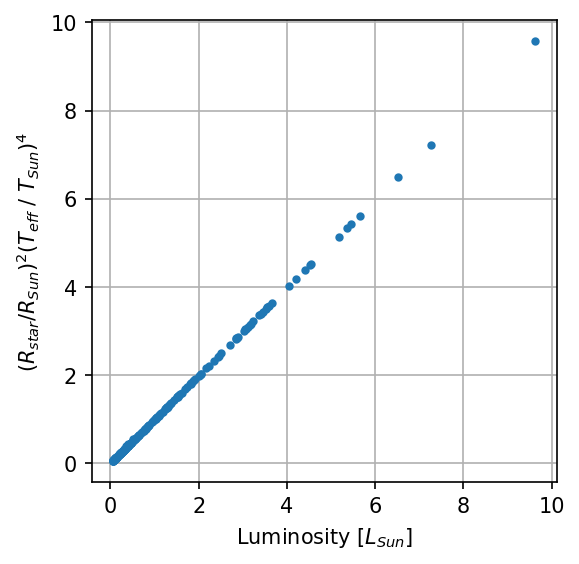

In [6]:
plt.figure(figsize=(4, 4), dpi=150) 
plt.plot(query_dr3['lum_flame'], (query_dr3['teff_gspphot']/5780)**4 * query_dr3['radius_flame']**2, '.')
plt.xlabel('Luminosity [$L_{Sun}$]')
plt.ylabel('$(R_{star}/R_{Sun})^2(T_{eff}$ / $T_{Sun})^4$')
plt.grid()

#### Query Gaia DR2

In [7]:
# Define the ADQL query

# query = """
# SELECT source_id, ra, dec, phot_g_mean_mag, phot_bp_mean_mag, phot_rp_mean_mag, parallax, teff_val
# FROM gaiadr2.gaia_source
# WHERE phot_g_mean_mag < 9
#   AND dec BETWEEN -90 AND 60
#   AND parallax >= 50
#   AND (duplicated_source = 'false' OR duplicated_source IS NULL)
#   AND (phot_bp_mean_mag - phot_rp_mean_mag) BETWEEN 0.5 AND 2.0
# """

query = """
SELECT gs.source_id, gs.ra, gs.dec, gs.phot_g_mean_mag, gs.phot_bp_mean_mag, gs.phot_rp_mean_mag, gs.parallax, gs.teff_val, ap.mass_flame, ap.lum_flame
FROM gaiadr2.gaia_source AS gs
JOIN gaiadr3.astrophysical_parameters AS ap ON gs.source_id = ap.source_id
WHERE gs.phot_g_mean_mag < 9
  AND gs.dec BETWEEN -90 AND 60
  AND gs.parallax >= 50
  AND (gs.duplicated_source = 'false' OR gs.duplicated_source IS NULL)
  AND (gs.phot_bp_mean_mag - gs.phot_rp_mean_mag) BETWEEN 0.5 AND 2.0
  AND ap.mass_flame IS NOT NULL
  AND ap.lum_flame IS NOT NULL
"""

# note: adding the last constrint "ap.mass_flame IS NOT NULL" decreases the number of results from 325 to 172

# Execute the query
job = Gaia.launch_job(query)
query_dr2 = job.get_results()

# Print the results
query_dr2

source_id,ra,dec,phot_g_mean_mag,phot_bp_mean_mag,phot_rp_mean_mag,parallax,teff_val,mass_flame,lum_flame
,deg,deg,mag,mag,mag,mas,K,solMass,solLum
int64,float64,float64,float32,float32,float32,float64,float32,float32,float32
4911306239828325760,24.95057933205967,-56.19640157291552,5.6040273,6.110481,5.017446,122.13334113520919,5072.6665,0.7728912,0.31139687
4911306239828325632,24.95125177735008,-56.193253444734914,5.4815745,5.975546,4.9180384,122.05515593526933,5083.0,0.848425,0.3325382
4503794795019024000,282.1223322844829,10.743571121256357,7.5975785,8.204739,6.895321,59.26211802631218,4802.3335,0.74777335,0.23566432
4038724053986441856,271.5993956729909,-36.019748261251586,5.7883286,6.125644,5.3455925,58.12581270135795,5922.0,0.9937225,1.0418576
4912580642524184960,25.623352566889793,-53.74128518649365,5.354947,5.6769776,4.966038,57.655586404793524,6143.0,1.0749273,1.5767086
4623036865373793408,84.29927979496259,-80.4646040515499,5.4906683,5.8385477,5.064284,54.70524180803885,5960.5,1.0258615,1.5354643
1234693112077610880,221.59652203947957,16.492729215598665,8.710161,9.476045,7.900152,56.320803206408755,4253.005,0.64877063,0.112481706
1264630412816366720,226.82615129468738,24.86848696167738,4.757479,5.0543466,4.467854,51.66743878315765,6567.0,1.284035,3.4606323


#### overlapping sources

OK... note that DR2 and DR3 may not share the same source_id, so estimate below is less than what it should be.

In [8]:
# Assuming query_dr3 is already obtained similarly to query_dr2

# Extract the source_id columns from both results
source_ids_dr2 = query_dr2['source_id']
source_ids_dr3 = query_dr3['source_id']

# Find the intersection of source_ids between DR2 and DR3
overlapping_source_ids = set(source_ids_dr2).intersection(set(source_ids_dr3))

# Print the overlapping source_ids
print(f"Number of overlapping source_ids: {len(overlapping_source_ids)}")
print(overlapping_source_ids)


Number of overlapping source_ids: 162
{1244571953471006720, 3575733210781078016, 5835498883232034816, 6171492113110925312, 5760701787150565888, 3865002247461685248, 4634528720388462592, 6018047019138644480, 1359938520253565952, 3724242219117947904, 6471497502884511232, 6009538585839374336, 3478127463341507072, 1605198298364601088, 5160075762132996992, 683184784030475520, 714116137767540096, 3101923001490347392, 5951165616611763456, 4745373133284418816, 746545172372256384, 2920772722738017920, 2904830113367963264, 4503794795019024000, 2473608009504466688, 1462061709995883136, 4038724053986441856, 6847167606385195648, 6490470881687779968, 1264630412816366720, 5808612830236138368, 3498481519515679872, 5726982995343100928, 5381537023379295232, 1833199729671740800, 70051608089857536, 4419140645978987904, 777254360337133312, 952326504452337792, 4467355158571184256, 3256786534197166208, 1821708351374312064, 892215482207937152, 2552925644460225152, 3852570413083923072, 4389844948935164544, 646

### 2. List star names and object types

In [6]:
from astroquery.simbad import Simbad
from astroquery.gaia import Gaia

# Customize Simbad to include the HD, GJ, and HIP identifiers and object type
custom_simbad = Simbad()
custom_simbad.add_votable_fields('ids', 'otype')

# Define the ADQL query to get Gaia source IDs
query = """
SELECT source_id, ra, dec, phot_g_mean_mag, phot_bp_mean_mag, phot_rp_mean_mag, parallax, teff_gspphot
FROM gaiadr3.gaia_source
WHERE phot_g_mean_mag < 9
  AND dec BETWEEN -90 AND 60
  AND parallax >= 50
  AND (duplicated_source = 'false' OR duplicated_source IS NULL)
  AND (phot_bp_mean_mag - phot_rp_mean_mag) BETWEEN 0.5 AND 2.0
"""

# Execute the query
job = Gaia.launch_job(query)
results = job.get_results()

# Extract Gaia source IDs
source_ids = results['source_id']

# Dictionary to collect object types
object_types_collected = {}

# Query Simbad for each Gaia source ID and filter for HD, GJ, and HIP numbers and object types
for source_id in source_ids:
    result_table = custom_simbad.query_object(f"Gaia DR3 {source_id}")
    if result_table is not None:
        ids = result_table['IDS'][0].split('|')
        hd_numbers = [id.strip() for id in ids if id.startswith('HD')]
        gj_numbers = [id.strip() for id in ids if id.startswith('GJ')]
        hip_numbers = [id.strip() for id in ids if id.startswith('HIP')]
        object_type = result_table['OTYPE'][0]

        # Collect object types
        if object_type not in object_types_collected:
            object_types_collected[object_type] = 0
        object_types_collected[object_type] += 1

        if hd_numbers:
            print(f"Gaia DR3 {source_id}: HD Number(s): {hd_numbers}, Object Type: {object_type}")
        elif gj_numbers:
            print(f"Gaia DR3 {source_id}: GJ Number(s): {gj_numbers}, Object Type: {object_type}")
        elif hip_numbers:
            print(f"Gaia DR3 {source_id}: HIP Number(s): {hip_numbers}, Object Type: {object_type}")
        else:
            print(f"Gaia DR3 {source_id}: No HD, GJ, or HIP number found, Object Type: {object_type}")
    else:
        print(f"No alternative names or object type found for Gaia DR3 {source_id}")

# Print all collected object types
print("\nCollected Object Types:")
for object_type, count in object_types_collected.items():
    print(f"{object_type}: {count}")


Gaia DR3 4683897617110115200: HD Number(s): ['HD   2151'], Object Type: HighPM*
Gaia DR3 5698015743046182272: HD Number(s): ['HD  67523'], Object Type: delSctV*
Gaia DR3 5826168461855385472: HD Number(s): ['HD 141891'], Object Type: HighPM*
Gaia DR3 6838311796136238976: HD Number(s): ['HD 207098'], Object Type: SB*
Gaia DR3 4269932382607207040: HD Number(s): ['HD 168723'], Object Type: HighPM*
Gaia DR3 1018776176872261248: HD Number(s): ['HD  82328'], Object Type: HighPM*
Gaia DR3 3288921720025503360: HD Number(s): ['HD  30652'], Object Type: HighPM*
Gaia DR3 1014058103758571520: GJ Number(s): ['GJ 331.0', 'GJ 331 A'], Object Type: SB*
Gaia DR3 5849837854861497856: HD Number(s): ['HD 128898'], Object Type: alf2CVnV*
Gaia DR3 4594497769766809216: HD Number(s): ['HD 161797', 'HD 161797A'], Object Type: **
Gaia DR3 3352485999058854912: HD Number(s): ['HD  48737'], Object Type: HighPM*
Gaia DR3 5164120762333028736: HD Number(s): ['HD  23249'], Object Type: HighPM*
Gaia DR3 2452378776434477


HighPM*: High Proper Motion Star. These stars have significant movement across the sky relative to more distant stars, indicating they are relatively close to Earth.

delSctV*: Delta Scuti Variable Star. These are pulsating variables with short periods of light variation, typically less than 0.3 days, found in the instability strip of the Hertzsprung-Russell diagram.

SB*: Spectroscopic Binary. A binary star system in which the stars are too close to be resolved individually but can be detected through their spectral lines.

alf2CVnV*: Alpha2 Canum Venaticorum Variable Star. These are chemically peculiar stars with strong magnetic fields and spectral lines that vary with the star's rotation.

**: Double or Multiple Star. A system of two or more stars that are gravitationally bound to each other.

BYDraV*: BY Draconis Variable Star. These are main-sequence variable stars showing light variations due to rotational modulation of star spots.

Variable*: Variable Star. A star whose brightness as seen from Earth fluctuates.

Eruptive*: Eruptive Variable Star. Stars that show sudden changes in brightness due to eruptions or flares.

RotV*: Rotational Variable Star. Stars whose brightness variations are due to rotation.

RSCVnV*: RS Canum Venaticorum Variable Star. These are close binary stars with active chromospheres, showing variations due to star spots and eclipses.

RGB*: Red Giant Branch Star. A star in a late phase of stellar evolution, characterized by expansion and cooling of the outer layers.

TTauri*: T Tauri Star. A very young star still in the process of gravitational contraction, often surrounded by a protoplanetary disk.

Star: A self-luminous celestial body consisting of a mass of gas held together by its own gravity.

EclBin: Eclipsing Binary. A binary star system where the orbital plane is aligned with our line of sight, causing the stars to eclipse each other.

Low-Mass*: Low-Mass Star. A star with a mass lower than approximately 0.5 solar masses, often including red dwarfs.

ChemPec*: Chemically Peculiar Star. Stars with unusual abundances of certain elements in their atmospheres.

### 3. Export to Excel

#### DR3

In [45]:
import pandas as pd
from astroquery.simbad import Simbad
from astroquery.gaia import Gaia
from openpyxl import load_workbook

# Customize Simbad to include the HD, GJ, and HIP identifiers and object type
custom_simbad = Simbad()
custom_simbad.add_votable_fields('ids', 'otype')

# Define the ADQL query to get Gaia source IDs
# query = """
# SELECT source_id, ra, dec, phot_g_mean_mag, phot_bp_mean_mag, phot_rp_mean_mag, parallax, teff_gspphot
# FROM gaiadr3.gaia_source
# WHERE phot_g_mean_mag < 9
#   AND dec BETWEEN -90 AND 60
#   AND parallax >= 50
#   AND (duplicated_source = 'false' OR duplicated_source IS NULL)
#   AND (phot_bp_mean_mag - phot_rp_mean_mag) BETWEEN 0.5 AND 2.0
# """

query = """
SELECT gs.source_id, gs.ra, gs.dec, gs.phot_g_mean_mag, gs.phot_bp_mean_mag, gs.phot_rp_mean_mag, gs.bp_rp, gs.parallax, gs.teff_gspphot, ap.mass_flame, ap.lum_flame, ap.radius_flame
FROM gaiadr3.gaia_source AS gs
JOIN gaiadr3.astrophysical_parameters AS ap ON gs.source_id = ap.source_id
WHERE gs.phot_g_mean_mag < 9
  AND gs.dec BETWEEN -90 AND 60
  AND gs.parallax >= 50
  AND (gs.duplicated_source = 'false' OR gs.duplicated_source IS NULL)
  AND (gs.phot_bp_mean_mag - gs.phot_rp_mean_mag) BETWEEN 0.5 AND 2.0
"""

'''
  AND ap.mass_flame IS NOT NULL
  AND ap.lum_flame IS NOT NULL
  AND ap.radius_flame IS NOT NULL
'''

# Execute the query
job = Gaia.launch_job(query)
results = job.get_results()

# Extract Gaia source IDs
source_ids = results['source_id']

# Initialize lists to store data
data = {
    'Gaia DR3 Source ID': [],
    'RA': [],
    'DEC': [],
    'Phot G Mean Mag': [],
    'Phot BP Mean Mag': [],
    'Phot RP Mean Mag': [],
    'Parallax': [],
    'T_eff [K]': [],
    'Stellar Mass': [],
    'Luminosity': [],
    'Radius [R_Sun]': [],
    'HD Number': [],
    'GJ Number': [],
    'HIP Number': [],
    'Object Type': []
}

# Query Simbad for each Gaia source ID and filter for HD, GJ, and HIP numbers and object types
for source_id in source_ids:
    result_table = custom_simbad.query_object(f"Gaia DR3 {source_id}")
    hd_numbers = []
    gj_numbers = []
    hip_numbers = []
    object_type = None
    
    if result_table is not None:
        ids = result_table['IDS'][0].split('|')
        hd_numbers = [id.strip() for id in ids if id.startswith('HD')]
        gj_numbers = [id.strip() for id in ids if id.startswith('GJ')]
        hip_numbers = [id.strip() for id in ids if id.startswith('HIP')]
        object_type = result_table['OTYPE'][0]

    data['Gaia DR3 Source ID'].append(str(source_id))  # Convert source_id to string
    data['RA'].append(results['ra'][source_ids == source_id][0])
    data['DEC'].append(results['dec'][source_ids == source_id][0])
    data['Phot G Mean Mag'].append(results['phot_g_mean_mag'][source_ids == source_id][0])
    data['Phot BP Mean Mag'].append(results['phot_bp_mean_mag'][source_ids == source_id][0])
    data['Phot RP Mean Mag'].append(results['phot_rp_mean_mag'][source_ids == source_id][0])
    data['Parallax'].append(results['parallax'][source_ids == source_id][0])
    data['T_eff [K]'].append(results['teff_gspphot'][source_ids == source_id][0])
    data['Stellar Mass'].append(results['mass_flame'][source_ids == source_id][0])
    data['Luminosity [L_Sun]'].append(results['lum_flame'][source_ids == source_id][0])
    data['Radius [R_Sun]'].append(results['radius_flame'][source_ids == source_id][0])
    data['HD Number'].append(', '.join(hd_numbers) if hd_numbers else None)
    data['GJ Number'].append(', '.join(gj_numbers) if gj_numbers else None)
    data['HIP Number'].append(', '.join(hip_numbers) if hip_numbers else None)
    data['Object Type'].append(object_type)

# Convert the data to a pandas DataFrame
df = pd.DataFrame(data)

# Export the DataFrame to an Excel file
directory = '../results/'
excel_file = 'query_dr3.xlsx'
output_path = directory + excel_file
df.to_excel(output_path, index=False)

# Load the workbook and select the active worksheet
workbook = load_workbook(output_path)
worksheet = workbook.active

# Adjust the column widths
adjust_column_widths(output_path)


In [10]:
result_table = custom_simbad.query_object(f"Gaia DR3 {source_ids[0]}")
result_table

MAIN_ID,RA,DEC,RA_PREC,DEC_PREC,COO_ERR_MAJA,COO_ERR_MINA,COO_ERR_ANGLE,COO_QUAL,COO_WAVELENGTH,COO_BIBCODE,IDS,OTYPE,SCRIPT_NUMBER_ID
,"""h:m:s""","""d:m:s""",,,mas,mas,deg,,,,,,
object,str13,str13,int16,int16,float32,float32,int16,str1,str1,object,object,object,int32
* pi.03 Ori,04 49 50.4112,+06 57 40.600,14,14,0.168,0.087,90,A,O,2020yCat.1350....0G,LTT 11517|* 1 Ori|* pi.03 Ori|** STT 560A|ASCC 1010229|BD+06 762|CCDM J04499+0657A|Ci 20 306|CNS5 1208|CSI+06 762 1|CSV 100411|1ES 0447+06.8|2EUVE J0449+06.9|EUVE J0449+06.9|FK5 1134|GC 5875|GCRV 2837|GEN# +1.00030652|GJ 178|HD 30652|HIC 22449|HIP 22449|HR 1543|IDS 04444+0647 A|IRAS 04471+0652|IRC +10071|JP11 931|LSPM J0449+0657|2MASS J04495040+0657409|N30 1028|NAME Tabit|NLTT 14011|NSV 1731|PLX 1077|PLX 1077.00|PMC 90-93 758|PPM 148020|RAVE J044950.4+065741|2RE J044951+065736|2RE J0449+065|RE J0449+065|RE J044950+065733|ROT 683|1RXS J044950.6+065736|SAO 112106|SKY# 7512|SPOCS 230|SRS 31134|SV* ZI 311|TD1 3592|TIC 399665349|TYC 96-1462-1|UBV 4635|UBV M 10360|USNO-B1.0 0969-00046662|USNO 809|uvby98 100030652|WDS J04498+0658A|WEB 4331|YZ 6 1810|Zkh 65|Gaia DR2 3288921720024442496|Gaia DR3 3288921720025503360,HighPM*,1


In [11]:
if result_table is not None:
    ids = result_table['IDS'][0].split('|')
    hd_numbers = [id.strip() for id in ids if id.startswith('HD')]
    gj_numbers = [id.strip() for id in ids if id.startswith('GJ')]
    hip_numbers = [id.strip() for id in ids if id.startswith('HIP')]
    object_type = result_table['OTYPE'][0]

hd_numbers, gj_numbers, hip_numbers, object_type

(['HD  30652'], ['GJ 178'], ['HIP 22449'], 'HighPM*')

#### DR2

In [46]:
import pandas as pd
from astroquery.simbad import Simbad
from astroquery.gaia import Gaia
from openpyxl import load_workbook

# Customize Simbad to include the HD, GJ, and HIP identifiers and object type
custom_simbad = Simbad()
custom_simbad.add_votable_fields('ids', 'otype')

# Define the ADQL query for Gaia DR2
# query_dr2 = """
# SELECT source_id, ra, dec, phot_g_mean_mag, phot_bp_mean_mag, phot_rp_mean_mag, parallax, teff_val
# FROM gaiadr2.gaia_source
# WHERE phot_g_mean_mag < 9
#   AND dec BETWEEN -90 AND 60
#   AND parallax >= 50
#   AND (duplicated_source = 'false' OR duplicated_source IS NULL)
#   AND (phot_bp_mean_mag - phot_rp_mean_mag) BETWEEN 0.5 AND 2.0
# """

query_dr2 = """
SELECT gs.source_id, gs.ra, gs.dec, gs.phot_g_mean_mag, gs.phot_bp_mean_mag, gs.phot_rp_mean_mag, gs.parallax, gs.teff_val, ap.mass_flame, ap.lum_flame, ap.radius_flame
FROM gaiadr2.gaia_source AS gs
JOIN gaiadr3.astrophysical_parameters AS ap ON gs.source_id = ap.source_id
WHERE gs.phot_g_mean_mag < 9
  AND gs.dec BETWEEN -90 AND 60
  AND gs.parallax >= 50
  AND (gs.duplicated_source = 'false' OR gs.duplicated_source IS NULL)
  AND (gs.phot_bp_mean_mag - gs.phot_rp_mean_mag) BETWEEN 0.5 AND 2.0

"""

'''
  AND ap.mass_flame IS NOT NULL
  AND ap.lum_flame IS NOT NULL
  AND ap.radius_flame IS NOT NULL
'''
# Execute the query for DR2
job_dr2 = Gaia.launch_job(query_dr2)
query_dr2 = job_dr2.get_results()

# Extract Gaia source IDs for DR2
source_ids_dr2 = query_dr2['source_id']

# Initialize lists to store data for DR2
data_dr2 = {
    'Gaia DR2 Source ID': [],
    'RA': [],
    'DEC': [],
    'Phot G Mean Mag': [],
    'Phot BP Mean Mag': [],
    'Phot RP Mean Mag': [],
    'Parallax': [],
    'T_eff [K]': [],
    'Stellar Mass': [],
    'Luminosity [L_Sun]': [],
    'Radius [R_Sun]': [],
    'HD Number': [],
    'GJ Number': [],
    'HIP Number': [],
    'Object Type': []
}

# Query Simbad for each Gaia source ID in DR2 and filter for HD, GJ, and HIP numbers and object types
for source_id in source_ids_dr2:
    result_table = custom_simbad.query_object(f"Gaia DR2 {source_id}")
    hd_numbers = []
    gj_numbers = []
    hip_numbers = []
    object_type = None
    
    if result_table is not None:
        ids = result_table['IDS'][0].split('|')
        hd_numbers = [id.strip() for id in ids if id.startswith('HD')]
        gj_numbers = [id.strip() for id in ids if id.startswith('GJ')]
        hip_numbers = [id.strip() for id in ids if id.startswith('HIP')]
        object_type = result_table['OTYPE'][0]

    data_dr2['Gaia DR2 Source ID'].append(str(source_id))  # Convert source_id to string
    data_dr2['RA'].append(query_dr2['ra'][source_ids_dr2 == source_id][0])
    data_dr2['DEC'].append(query_dr2['dec'][source_ids_dr2 == source_id][0])
    data_dr2['Phot G Mean Mag'].append(query_dr2['phot_g_mean_mag'][source_ids_dr2 == source_id][0])
    data_dr2['Phot BP Mean Mag'].append(query_dr2['phot_bp_mean_mag'][source_ids_dr2 == source_id][0])
    data_dr2['Phot RP Mean Mag'].append(query_dr2['phot_rp_mean_mag'][source_ids_dr2 == source_id][0])
    data_dr2['Parallax'].append(query_dr2['parallax'][source_ids_dr2 == source_id][0])
    data_dr2['T_eff [K]'].append(query_dr2['teff_val'][source_ids_dr2 == source_id][0])
    data_dr2['Stellar Mass'].append(query_dr2['mass_flame'][source_ids_dr2 == source_id][0])
    data_dr2['Luminosity [L_Sun]'].append(query_dr2['lum_flame'][source_ids_dr2 == source_id][0])
    data_dr2['Radius [R_Sun]'].append(query_dr2['radius_flame'][source_ids_dr2 == source_id][0])
    data_dr2['HD Number'].append(', '.join(hd_numbers) if hd_numbers else None)
    data_dr2['GJ Number'].append(', '.join(gj_numbers) if gj_numbers else None)
    data_dr2['HIP Number'].append(', '.join(hip_numbers) if hip_numbers else None)
    data_dr2['Object Type'].append(object_type)

# Convert the data to a pandas DataFrame for DR2
df_dr2 = pd.DataFrame(data_dr2)

# Export the DataFrame to an Excel file for DR2
excel_file_dr2 = 'query_dr2.xlsx'
output_path_dr2 = directory + excel_file_dr2
df_dr2.to_excel(output_path_dr2, index=False)

# Load the workbook and select the active worksheet for DR2
workbook_dr2 = load_workbook(output_path_dr2)
worksheet_dr2 = workbook_dr2.active

# Adjust the column widths for DR2
adjust_column_widths(output_path_dr2)


#### Merging dr2 and dr3

In [13]:
# Load the DR2 and DR3 data from the Excel files
df_dr2 = pd.read_excel(directory + 'query_dr2.xlsx')
df_dr3 = pd.read_excel(directory + 'query_dr3.xlsx')

# Ensure that 'Gaia DR2 Source ID' and 'Gaia DR3 Source ID' are strings
df_dr2['Gaia DR2 Source ID'] = df_dr2['Gaia DR2 Source ID'].astype(str)
df_dr3['Gaia DR3 Source ID'] = df_dr3['Gaia DR3 Source ID'].astype(str)

# Merge the two DataFrames on 'source_id', keeping all entries
merged_df = pd.merge(df_dr2, df_dr3, left_on='Gaia DR2 Source ID', right_on='Gaia DR3 Source ID', suffixes=('_dr2', '_dr3'), how='outer')

# Replace '--' with NaN in the merged DataFrame
merged_df['Teff_dr3'] = merged_df['Teff_dr3'].replace("--", np.nan)
print("Merged DataFrame:")
display(merged_df)

combined_data = {
    'Source ID': merged_df['Gaia DR2 Source ID'].combine_first(merged_df['Gaia DR3 Source ID']).astype(str),
    'RA': merged_df['RA_dr3'].combine_first(merged_df['RA_dr2']),
    'DEC': merged_df['DEC_dr3'].combine_first(merged_df['DEC_dr2']),
    'Phot G Mean Mag': merged_df['Phot G Mean Mag_dr3'].combine_first(merged_df['Phot G Mean Mag_dr2']),
    'Phot BP Mean Mag': merged_df['Phot BP Mean Mag_dr3'].combine_first(merged_df['Phot BP Mean Mag_dr2']),
    'Phot RP Mean Mag': merged_df['Phot RP Mean Mag_dr3'].combine_first(merged_df['Phot RP Mean Mag_dr2']),
    'Parallax': merged_df['Parallax_dr3'].combine_first(merged_df['Parallax_dr2']),
    'T_eff [K]': merged_df['Teff_dr3'].combine_first(merged_df['Teff_dr2']),
    'Stellar Mass': merged_df['Stellar Mass_dr3'].combine_first(merged_df['Stellar Mass_dr2']),
    'Luminosity [L_Sun]': merged_df['Luminosity_dr3'].combine_first(merged_df['Luminosity_dr2']),
    'Radius [R_Sun]': merged_df['Radius_dr3'].combine_first(merged_df['Radius_dr2']),
    'HD Number': merged_df['HD Number_dr3'].combine_first(merged_df['HD Number_dr2']),
    'GJ Number': merged_df['GJ Number_dr3'].combine_first(merged_df['GJ Number_dr2']),
    'HIP Number': merged_df['HIP Number_dr3'].combine_first(merged_df['HIP Number_dr2']),
    'Object Type': merged_df['Object Type_dr3'].combine_first(merged_df['Object Type_dr2']),
}

# Convert the combined data into a DataFrame
combined_df = pd.DataFrame(combined_data)

Merged DataFrame:


,Gaia DR2 Source ID,RA_dr2,DEC_dr2,Phot G Mean Mag_dr2,Phot BP Mean Mag_dr2,Phot RP Mean Mag_dr2,Parallax_dr2,Teff_dr2,Stellar Mass_dr2,Luminosity_dr2,...,Phot RP Mean Mag_dr3,Parallax_dr3,Teff_dr3,Stellar Mass_dr3,Luminosity_dr3,Radius_dr3,HD Number_dr3,GJ Number_dr3,HIP Number_dr3,Object Type_dr3
0,4911306239828325760,24.950579,-56.196402,5.604027,6.110481,5.017446,122.133341,5072.666504,0.772891,0.311397,...,4.995800,122.003472,4902.265137,0.772891,0.311397,0.773601,HD 10361,GJ 66 A,NaN,HighPM*
1,4911306239828325632,24.951252,-56.193253,5.481575,5.975546,4.918038,122.055156,5083.000000,0.848425,0.332538,...,4.886207,122.108813,5044.240234,0.848425,0.332538,0.755049,HD 10360,GJ 66 B,NaN,HighPM*
2,4503794795019024000,282.122332,10.743571,7.597579,8.204739,6.895321,59.262118,4802.333496,0.747773,0.235664,...,6.885082,59.234454,4542.218750,0.747773,0.235664,0.783907,HD 174080,GJ 727,HIP 92283,HighPM*
3,4038724053986441856,271.599396,-36.019748,5.788329,6.125644,5.345592,58.125813,5922.000000,0.993722,1.041858,...,5.326963,58.429633,5773.397461,0.993722,1.041858,1.020187,HD 165185,GJ 702.1,HIP 88694,HighPM*
4,4912580642524184960,25.623353,-53.741285,5.354947,5.676978,4.966038,57.655586,6143.000000,1.074927,1.576709,...,4.946809,57.640899,6011.648926,1.074927,1.576709,1.157568,HD 10647,GJ 3109,HIP 7978,HighPM*
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
223,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,6.115734,56.556967,5304.386230,0.831084,0.500709,0.878492,HD 21175,GJ 3222,HIP 15799,HighPM*
224,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,6.329168,57.865912,5015.698730,0.813205,0.402590,0.840273,HD 67199,GJ 3476,HIP 39342,HighPM*
225,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,6.398603,53.052628,5230.245605,0.866382,0.455258,0.821747,HD 4747,GJ 36,HIP 3850,SB*
226,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,7.031435,100.916060,3760.628174,0.605965,0.079379,0.663517,HD 232979,GJ 172,HIP 21553,Eruptive*


Gaia only provides B, R and G-band magnitudes, but the RV precision tool uses the V-band magnitudes. I've found a conversion from this paper <https://iopscience.iop.org/article/10.3847/2041-8213/aacdf6/pdf> (Table 2) from Gaia DR2, which should also work for Gaia DR3.

In [45]:
combined_df = df_filtered.copy()

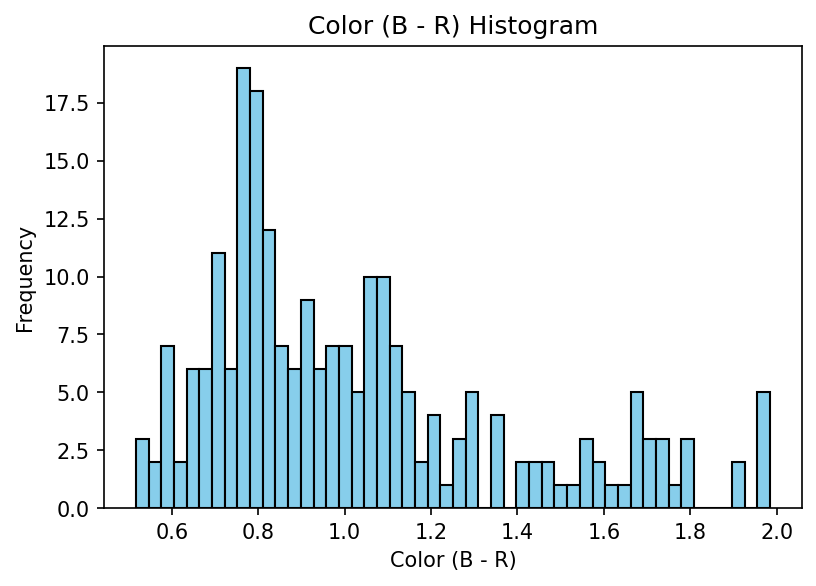

In [46]:
color = combined_df['Phot BP Mean Mag'] - combined_df['Phot RP Mean Mag']


# Create a high-resolution plot
plt.figure(figsize=(6, 4), dpi=150)  # Set the dpi to 300 for high resolution
plt.hist(color, bins=50, color='skyblue', edgecolor='black')
plt.xlabel('Color (B - R)')
plt.ylabel('Frequency')
plt.title('Color (B - R) Histogram')
plt.savefig('../figures/color_histogram.png', dpi=300)  # Save the plot as a PNG file
plt.show()

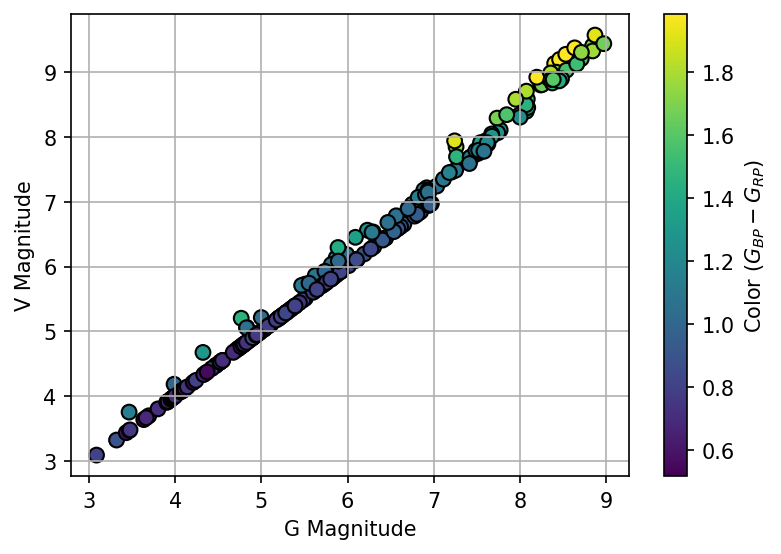

In [47]:

# Assuming 'color' is a column in combined_df or an array of the same length as the DataFrame
# For example, if 'color' is the difference between 'Phot BP Mean Mag' and 'Phot RP Mean Mag'
color = combined_df['Phot BP Mean Mag'] - combined_df['Phot RP Mean Mag']

# Calculate the conversion factor for colors between 1 and 4
conv = 0.20220 + 0.02489 * color

# Use np.where to apply the conversion conditionally
V_mag = np.where((color >= 1) & (color <= 4),
                 combined_df['Phot BP Mean Mag'] - conv,
                 combined_df['Phot G Mean Mag'])

# Create a high-resolution plot
plt.figure(figsize=(6, 4), dpi=150)  # Set the dpi to 300 for high resolution

# Plot the diagram using the color array for point colors
plt.scatter(combined_df['Phot G Mean Mag'], V_mag, c=color, cmap='viridis', edgecolor='k', s=50)
plt.xlabel('G Magnitude')
plt.ylabel('V Magnitude')
# plt.title('Color-Magnitude Diagram')
plt.colorbar(label='Color $(G_{BP} - G_{RP})$')
plt.grid()
plt.savefig('../figures/color_magnitude_diagram.png', dpi=300)
plt.show()


In [48]:
combined_df.head()

,source_id,source_id_dr2,source_id_dr3,RA,DEC,Phot G Mean Mag,Phot BP Mean Mag,Phot RP Mean Mag,BP-RP,Parallax,T_eff [K],Mass [M_Sun],Luminosity [L_Sun],Radius [R_Sun],Spectral Type,HD Number,GJ Number,HIP Number,Object Type
3,4911306239828325760,4911306239828325760,4911306239828325760,24.950657,-56.196400,5.625487,6.089998,4.995800,1.094198,122.003472,4902.265137,0.772891,0.311397,0.773601,G,HD 10361,GJ 66 A,None,HighPM*
4,4911306239828325632,4911306239828325632,4911306239828325632,24.951317,-56.193251,5.508302,5.956992,4.886207,1.070785,122.108813,5044.240234,0.848425,0.332538,0.755049,G,HD 10360,GJ 66 B,None,HighPM*
8,4503794795019024000,4503794795019024000,4503794795019024000,282.122350,10.743510,7.606561,8.177541,6.885082,1.292459,59.234454,4542.218750,0.747773,0.235664,0.783907,K,HD 174080,GJ 727,HIP 92283,HighPM*
9,4038724053986441856,4038724053986441856,4038724053986441856,271.599414,-36.019747,5.805398,6.107953,5.326963,0.780990,58.429633,5773.397461,0.993722,1.041858,1.020187,F,HD 165185,GJ 702.1,HIP 88694,HighPM*
10,4912580642524184960,4912580642524184960,4912580642524184960,25.623392,-53.741300,5.383109,5.657312,4.946809,0.710503,57.640899,6011.648926,1.074927,1.576709,1.157568,F,HD 10647,GJ 3109,HIP 7978,HighPM*


In [49]:
# Insert the 'V_mag' column right after the 'DEC' column
combined_df.insert(combined_df.columns.get_loc('DEC') + 1, 'V_mag', V_mag)

if 'T_eff [K]' in combined_df.columns:

    # Calculate the HZ_limit
    hz_limits = combined_df.apply(lambda row: calculate_habitable_zone(row['T_eff [K]'], row['Luminosity [L_Sun]']), axis=1)
    # Find the index of the 'Radius [R_Sun]' column
    radius_index = combined_df.columns.get_loc('Radius [R_Sun]')
    # Insert the new column after 'Radius [R_Sun]'
    combined_df.insert(radius_index + 1, 'HZ_limit [AU]', hz_limits)
    # Sort the DataFrame by temperature (Teff)
    combined_df = combined_df.sort_values('T_eff [K]')    

# Export the combined DataFrame to an Excel file
combined_excel_file = 'combined_query.xlsx'
output_path = directory + combined_excel_file
combined_df.to_excel(output_path, index=False)

print(f"Combined results saved to {output_path}")
display(combined_df.head())

# Adjust the column widths
adjust_column_widths(output_path)

Combined results saved to ../results/combined_query.xlsx


,source_id,source_id_dr2,source_id_dr3,RA,DEC,V_mag,Phot G Mean Mag,Phot BP Mean Mag,Phot RP Mean Mag,BP-RP,...,T_eff [K],Mass [M_Sun],Luminosity [L_Sun],Radius [R_Sun],HZ_limit [AU],Spectral Type,HD Number,GJ Number,HIP Number,Object Type
89,2683023811628007296,2683023811628007296,2683023811628007296,330.540802,1.398992,9.136045,8.403359,9.387209,7.420015,1.967194,...,3501.576416,0.577452,0.066803,0.702667,0.276365,M,HD 209290,GJ 846,HIP 108782,HighPM*
146,4282578724832056576,4282578724832056576,4282578724832056576,284.499690,5.902697,9.198853,8.460503,9.450294,7.471963,1.978331,...,3560.908936,0.586452,0.069564,0.692835,0.281779,M,HD 176029,GJ 740,HIP 93101,HighPM*
277,6673000841376349696,6673000841376349696,6673000841376349696,303.477391,-45.164731,7.940663,7.242661,8.190446,6.278736,1.911710,...,3588.520508,0.567104,0.061621,0.641908,0.265094,M,HD 191849,GJ 784,HIP 99701,HighPM*
185,4946938113149426944,4946938113149426944,4946938113149426944,38.594380,-43.797657,8.923683,8.196382,9.175138,7.196229,1.978910,...,3611.961182,0.624806,0.091748,0.771405,0.323350,M,HD 16157,GJ 103,HIP 11964,BYDraV*
105,70051608089857536,70051608089857536,70051608089857536,56.585833,26.214633,9.574198,8.871369,9.824131,7.906354,1.917777,...,3655.815186,0.596475,0.073706,0.684450,0.289614,M,HD 23453,GJ 154,HIP 17609,Eruptive*


### 4. Generate the parameter file

In [10]:
# Not used because we need to split the input into hot and cool stars
if 0:

    import pandas as pd

    # Create a new DataFrame for parameter_file.csv
    parameter_df = pd.DataFrame({
        'Name': combined_df['source_id'],
        'SpT': '',  # Empty column for SpT
        'Temperature': combined_df['T_eff [K]'],
        'Vmag': combined_df['V_mag'],
        'Jmag': ''  # Empty column for Jmag
    })

    # Save the new DataFrame to a CSV file
    output_path = directory + 'parameter_file.csv'
    parameter_df.to_csv(output_path, index=False)

    print(f"Parameter file has been saved as '{output_path}'")

    # Display the first few rows of the new DataFrame
    parameter_df.head()


In [11]:
import pandas as pd
import os

# Create a new DataFrame for parameter_file.csv
parameter_df = pd.DataFrame({
    'Name': combined_df['source_id'],
    'SpT': '',  # Empty column for SpT
    'Temperature': combined_df['T_eff [K]'],
    'Vmag': combined_df['V_mag'],
    'Jmag': ''  # Empty column for Jmag
})

# Separate rows based on temperature; refer to email from Zechmeister
cool_stars = parameter_df[parameter_df['Temperature'] < 4000]
hot_stars = parameter_df[parameter_df['Temperature'] >= 4000]

# Save the DataFrames to CSV files
output_path_cool = os.path.join(directory, 'parameter_file_cool.csv')
output_path_hot = os.path.join(directory, 'parameter_file_hot.csv')

cool_stars.to_csv(output_path_cool, index=False)
hot_stars.to_csv(output_path_hot, index=False)

print(f"Cool stars (T < 4000K) file has been saved as '{output_path_cool}'")
print(f"Hot stars (T >= 4000K) file has been saved as '{output_path_hot}'")

# Print the number of stars in each category
print(f"\nNumber of cool stars (T < 4000K): {len(cool_stars)}")
print(f"Number of hot stars (T >= 4000K): {len(hot_stars)}")

# Save the original parameter_df to a CSV file
output_path_all = os.path.join(directory, 'parameter_file_all.csv')
parameter_df.to_csv(output_path_all, index=False)

print(f"\nAll stars file has been saved as '{output_path_all}'")

Cool stars (T < 4000K) file has been saved as '../results/parameter_file_cool.csv'
Hot stars (T >= 4000K) file has been saved as '../results/parameter_file_hot.csv'

Number of cool stars (T < 4000K): 23
Number of hot stars (T >= 4000K): 204

All stars file has been saved as '../results/parameter_file_all.csv'


### Now go and retrive the RV precision from Reiners' tool 
.

.

.


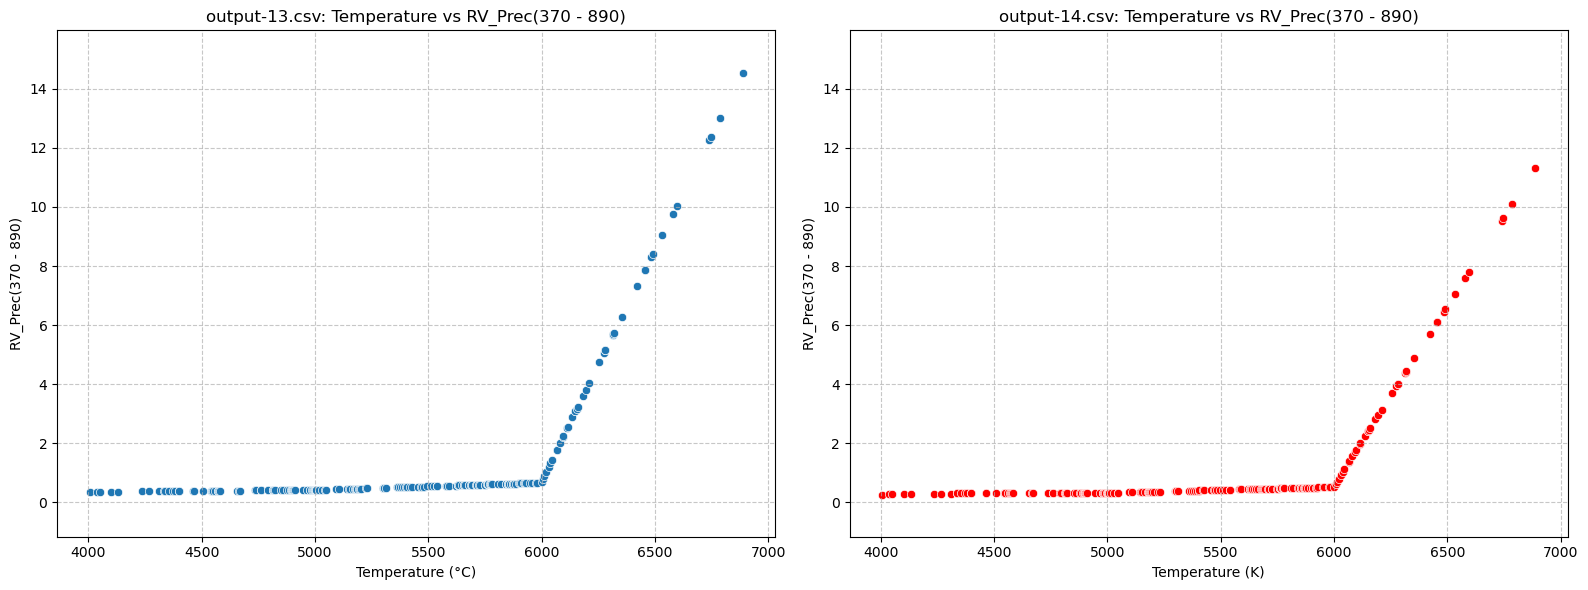


Statistics for output-13.csv:
       Temperature  RV_Prec(370 - 890)
count   204.000000          204.000000
mean   5434.354271            1.438080
std     643.194900            2.499872
min    4006.371826            0.338938
25%    4936.713745            0.408004
50%    5517.603760            0.542532
75%    5900.662476            0.637701
max    6887.404785           14.551520

Statistics for output-14.csv:
       Temperature  RV_Prec(370 - 890)
count   204.000000          204.000000
mean   5434.354271            1.117963
std     643.194900            1.943400
min    4006.371826            0.263490
25%    4936.713745            0.317182
50%    5517.603760            0.421765
75%    5900.662476            0.495749
max    6887.404785           11.312351

Correlation coefficient for output-13.csv: 0.6331
Correlation coefficient for output-14.csv: 0.6331


In [41]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Read the CSV files
df_13 = pd.read_csv('/Users/jinzhao/Downloads/output_t_obs_30.csv')
df_14 = pd.read_csv('/Users/jinzhao/Downloads/output_SNR_100.csv')

# Create a figure with two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Plot for output-13.csv
sns.scatterplot(data=df_13, x='Temperature', y='RV_Prec(370 - 890)', ax=ax1)
ax1.set_xlabel('Temperature (°C)')
ax1.set_ylabel('RV_Prec(370 - 890)')
ax1.set_title('output-13.csv: Temperature vs RV_Prec(370 - 890)')
ax1.grid(True, linestyle='--', alpha=0.7)

# Plot for output-14.csv
sns.scatterplot(data=df_14, x='Temperature', y='RV_Prec(370 - 890)', ax=ax2, color='red')
ax2.set_xlabel('Temperature (K)')
ax2.set_ylabel('RV_Prec(370 - 890)')
ax2.set_title('output-14.csv: Temperature vs RV_Prec(370 - 890)')
ax2.grid(True, linestyle='--', alpha=0.7)

# Adjust y-axis limits to focus on the range of RV_Prec values
y_min = min(df_13['RV_Prec(370 - 890)'].min(), df_14['RV_Prec(370 - 890)'].min())
y_max = max(df_13['RV_Prec(370 - 890)'].max(), df_14['RV_Prec(370 - 890)'].max())
y_range = y_max - y_min
ax1.set_ylim(y_min - 0.1*y_range, y_max + 0.1*y_range)
ax2.set_ylim(y_min - 0.1*y_range, y_max + 0.1*y_range)

plt.tight_layout()
plt.show()

# Print basic statistics
print("\nStatistics for output-13.csv:")
print(df_13[['Temperature', 'RV_Prec(370 - 890)']].describe())
print("\nStatistics for output-14.csv:")
print(df_14[['Temperature', 'RV_Prec(370 - 890)']].describe())

# Calculate correlation coefficients
corr_13 = df_13['Temperature'].corr(df_13['RV_Prec(370 - 890)'])
corr_14 = df_14['Temperature'].corr(df_14['RV_Prec(370 - 890)'])

print(f"\nCorrelation coefficient for output-13.csv: {corr_13:.4f}")
print(f"Correlation coefficient for output-14.csv: {corr_14:.4f}")

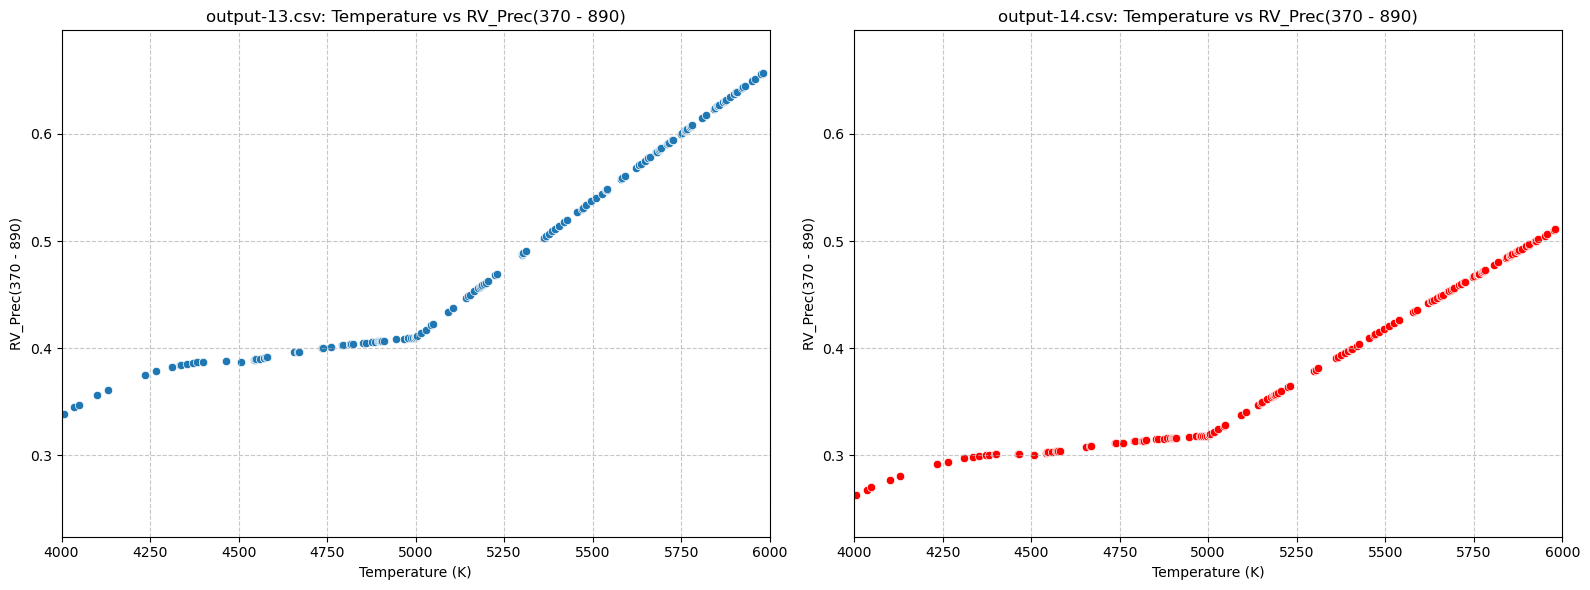


Statistics for output-13.csv (up to 6000 K):
       Temperature  RV_Prec(370 - 890)
count   162.000000          162.000000
mean   5215.549363            0.492417
std     522.733005            0.095294
min    4006.371826            0.338938
25%    4853.378174            0.405139
50%    5227.674072            0.468967
75%    5689.838989            0.585561
max    5980.538574            0.657326

Statistics for output-14.csv (up to 6000 K):
       Temperature  RV_Prec(370 - 890)
count   162.000000          162.000000
mean   5215.549363            0.382805
std     522.733005            0.074081
min    4006.371826            0.263490
25%    4853.378174            0.314955
50%    5227.674072            0.364575
75%    5689.838989            0.455215
max    5980.538574            0.511006

Correlation coefficient for output-13.csv (up to 6000 K): 0.9590
Correlation coefficient for output-14.csv (up to 6000 K): 0.9590


In [37]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Read the CSV files
df_13 = pd.read_csv('/Users/jinzhao/Downloads/output_t_obs_30.csv')
df_14 = pd.read_csv('/Users/jinzhao/Downloads/output_SNR_100.csv')

# Filter data up to 6000 K
df_13_filtered = df_13[df_13['Temperature'] <= 6000]
df_14_filtered = df_14[df_14['Temperature'] <= 6000]

# Create a figure with two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Plot for output-13.csv
sns.scatterplot(data=df_13_filtered, x='Temperature', y='RV_Prec(370 - 890)', ax=ax1)
ax1.set_xlabel('Temperature (K)')
ax1.set_ylabel('RV_Prec(370 - 890)')
ax1.set_title('output-13.csv: Temperature vs RV_Prec(370 - 890)')
ax1.grid(True, linestyle='--', alpha=0.7)
ax1.set_xlim(4000, 6000)

# Plot for output-14.csv
sns.scatterplot(data=df_14_filtered, x='Temperature', y='RV_Prec(370 - 890)', ax=ax2, color='red')
ax2.set_xlabel('Temperature (K)')
ax2.set_ylabel('RV_Prec(370 - 890)')
ax2.set_title('output-14.csv: Temperature vs RV_Prec(370 - 890)')
ax2.grid(True, linestyle='--', alpha=0.7)
ax2.set_xlim(4000, 6000)

# Adjust y-axis limits to focus on the range of RV_Prec values
y_min = min(df_13_filtered['RV_Prec(370 - 890)'].min(), df_14_filtered['RV_Prec(370 - 890)'].min())
y_max = max(df_13_filtered['RV_Prec(370 - 890)'].max(), df_14_filtered['RV_Prec(370 - 890)'].max())
y_range = y_max - y_min
ax1.set_ylim(y_min - 0.1*y_range, y_max + 0.1*y_range)
ax2.set_ylim(y_min - 0.1*y_range, y_max + 0.1*y_range)

plt.tight_layout()
plt.show()

# Print basic statistics for filtered data
print("\nStatistics for output-13.csv (up to 6000 K):")
print(df_13_filtered[['Temperature', 'RV_Prec(370 - 890)']].describe())
print("\nStatistics for output-14.csv (up to 6000 K):")
print(df_14_filtered[['Temperature', 'RV_Prec(370 - 890)']].describe())

# Calculate correlation coefficients for filtered data
corr_13 = df_13_filtered['Temperature'].corr(df_13_filtered['RV_Prec(370 - 890)'])
corr_14 = df_14_filtered['Temperature'].corr(df_14_filtered['RV_Prec(370 - 890)'])

print(f"\nCorrelation coefficient for output-13.csv (up to 6000 K): {corr_13:.4f}")
print(f"Correlation coefficient for output-14.csv (up to 6000 K): {corr_14:.4f}")

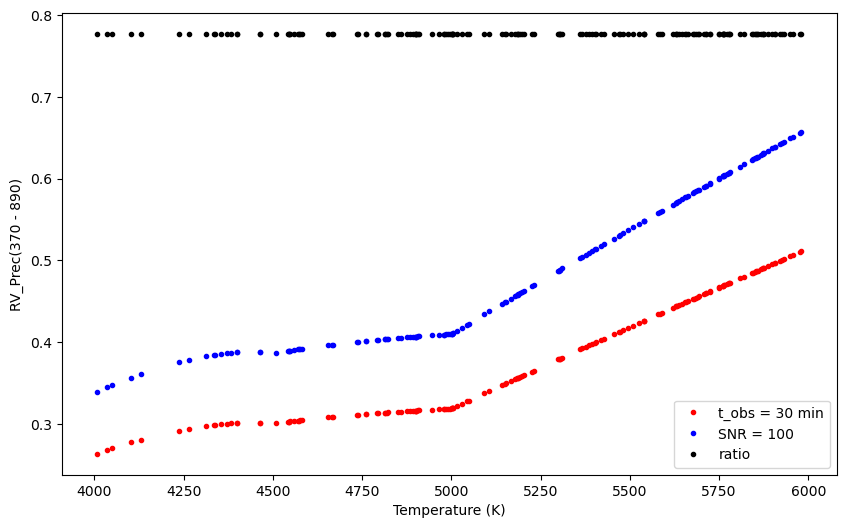

In [54]:
plt.subplots(figsize=(10, 6))
plt.plot(df_14_filtered['Temperature'], df_14_filtered['RV_Prec(370 - 890)'], '.', color='red', label='t_obs = 30 min')
plt.plot(df_13_filtered['Temperature'], df_13_filtered['RV_Prec(370 - 890)'], '.', color='blue', label='SNR = 100')
plt.plot(df_13_filtered['Temperature'], df_14_filtered['RV_Prec(370 - 890)']/ df_13_filtered['RV_Prec(370 - 890)'], '.', color='black', label='ratio')  
plt.xlabel('Temperature (K)')
plt.ylabel('RV_Prec(370 - 890)')
plt.legend()
# plt.savefig('', dpi=500)
plt.show()

In [43]:
df_13_filtered['RV_Prec(370 - 890)']/df_14_filtered['RV_Prec(370 - 890)']

0      1.286339
1      1.286339
2      1.286339
3      1.286339
4      1.286339
         ...   
157    1.286339
158    1.286339
159    1.286339
160    1.286339
161    1.286339
Name: RV_Prec(370 - 890), Length: 162, dtype: float64

In [50]:
from rv_prec import calculate_rv_precision

rv_precisions = []

for i in range(len(combined_df)):
    result, rv_precision = calculate_rv_precision(Temp=combined_df.iloc[i]['T_eff [K]'], Vmag=combined_df.iloc[i]['V_mag'])
    rv_precisions.append(rv_precision)

In [51]:
# Find the index of 'HZ_limit [AU]' column
hz_limit_index = combined_df.columns.get_loc('HZ_limit [AU]')

# Insert the rv_precisions to the right of 'HZ_limit [AU]'
combined_df.insert(hz_limit_index + 1, 'RV precision [m/s]', rv_precisions)

In [52]:
merged_df = combined_df.copy()

# Save the updated Excel file
output_path = directory + 'combined_query_with_RV_precision.xlsx'
merged_df.to_excel(output_path, index=False)

# Adjust the column widths
adjust_column_widths(output_path)

### Merge RV_prec into query

In [27]:
# Read the RV precision CSV files
df_csv_cool = pd.read_csv(directory + 'output_cool.csv', dtype={'Id': str})
df_csv_hot = pd.read_csv(directory + 'output_hot.csv', dtype={'Id': str})

# Merge the dataframes
df_merged = pd.concat([df_csv_cool, df_csv_hot], ignore_index=True)

# Save the merged dataframe to a new CSV file
output_merged = os.path.join(directory, 'output_all.csv')
df_merged.to_csv(output_merged, index=False)


In [28]:
# Read the CSV file
# df_csv = pd.read_csv(directory + 'output_all.csv', dtype={'Id': str})

# Change notation
df_csv = df_merged

# Merge the dataframes based on the ID columns
merged_df = pd.merge(combined_df, df_csv[['Id', 'RV_Prec(370 - 890)']], left_on='Source ID', right_on='Id', how='outer')

# Clean up and rename columns
merged_df = merged_df.drop(columns=['Id'])
merged_df = merged_df.rename(columns={'RV_Prec(370 - 890)': 'RV precision [m/s]'})

# Reorder columns to put "RV precision" next to "HZ_limit [AU]"
cols        = merged_df.columns.tolist()
hz_index    = cols.index("HZ_limit [AU]")
cols.insert(hz_index + 1, cols.pop(cols.index("RV precision [m/s]")))
merged_df   = merged_df[cols]

# Save the updated Excel file
output_path = directory + 'combined_query_with_RV_precision.xlsx'
merged_df.to_excel(output_path, index=False)

# Adjust the column widths
adjust_column_widths(output_path)

print(f"Updated Excel file has been saved as '{output_path}'")


Updated Excel file has been saved as '../results/combined_query_with_RV_precision.xlsx'


### Calculate the HZ mass detection limit

In [53]:
from scipy import optimize

# Constants
G = 6.67430e-11  # Gravitational constant in m^3 kg^-1 s^-2
M_earth = 5.97e24  # Earth mass in kg
M_sun = 1.989e30  # Solar mass in kg
AU = 1.496e11  # 1 AU in meters

def calculate_hz_detection_limit(K, stellar_mass, orbital_radius):
    """
    Calculate the minimum detectable planet mass in the Habitable Zone.
    
    :param K: RV precision in m/s
    :param stellar_mass: Mass of the star in solar masses
    :param orbital_radius: Orbital radius (HZ limit) in AU
    :return: Minimum detectable planet mass in Earth masses or np.nan if calculation fails
    """
    try:
        stellar_mass_kg = stellar_mass * M_sun
        orbital_radius_m = orbital_radius * AU
        
        if K <= 0 or stellar_mass_kg <= 0 or orbital_radius_m <= 0:
            return np.nan
        
        def equation(m_p):
            return K - (G**(1/2) * orbital_radius_m**(-1/2) * m_p * (stellar_mass_kg + m_p)**(-1/2))
        
        # Use numerical method to solve the equation
        planet_mass_kg = optimize.brentq(equation, 0, stellar_mass_kg)
        
        return planet_mass_kg / M_earth
    except:
        return np.nan

# Apply the calculation to each row
merged_df['HZ Detection Limit [Earth Mass]'] = merged_df.apply(
    lambda row: calculate_hz_detection_limit(
        row['RV precision [m/s]'],
        row['Mass [M_Sun]'],
        row['HZ_limit [AU]']
    ),
    axis=1
)

# Print some statistics about the new column
print(merged_df['HZ Detection Limit [Earth Mass]'].describe())

# Count and print the number of NaN values
nan_count = merged_df['HZ Detection Limit [Earth Mass]'].isna().sum()
print(f"Number of NaN values: {nan_count}")

# Reorder the columns to place the new column next to 'Mass'
cols = merged_df.columns.tolist()
mass_index = cols.index('RV precision [m/s]')
cols.insert(mass_index + 1, cols.pop(cols.index('HZ Detection Limit [Earth Mass]')))
merged_df = merged_df[cols]

# Save the updated DataFrame
output_path = directory + 'combined_query_with_mass_detection_limit.xlsx'
merged_df.to_excel(output_path, index=False)

# Adjust the column widths
adjust_column_widths(output_path)

print(f"Updated DataFrame saved to '{output_path}'.")


count    227.000000
mean       2.678016
std        4.413993
min        0.246737
25%        0.991282
50%        1.288627
75%        1.590742
max       24.143052
Name: HZ Detection Limit [Earth Mass], dtype: float64
Number of NaN values: 0
Updated DataFrame saved to '../results/combined_query_with_mass_detection_limit.xlsx'.


### Statistics and plots

In [57]:
print(merged_df.columns.tolist())

['source_id', 'source_id_dr2', 'source_id_dr3', 'RA', 'DEC', 'V_mag', 'Phot G Mean Mag', 'Phot BP Mean Mag', 'Phot RP Mean Mag', 'BP-RP', 'Parallax', 'T_eff [K]', 'Mass [M_Sun]', 'Luminosity [L_Sun]', 'Radius [R_Sun]', 'HZ_limit [AU]', 'RV precision [m/s]', 'HZ Detection Limit [Earth Mass]', 'Spectral Type', 'HD Number', 'GJ Number', 'HIP Number', 'Object Type']


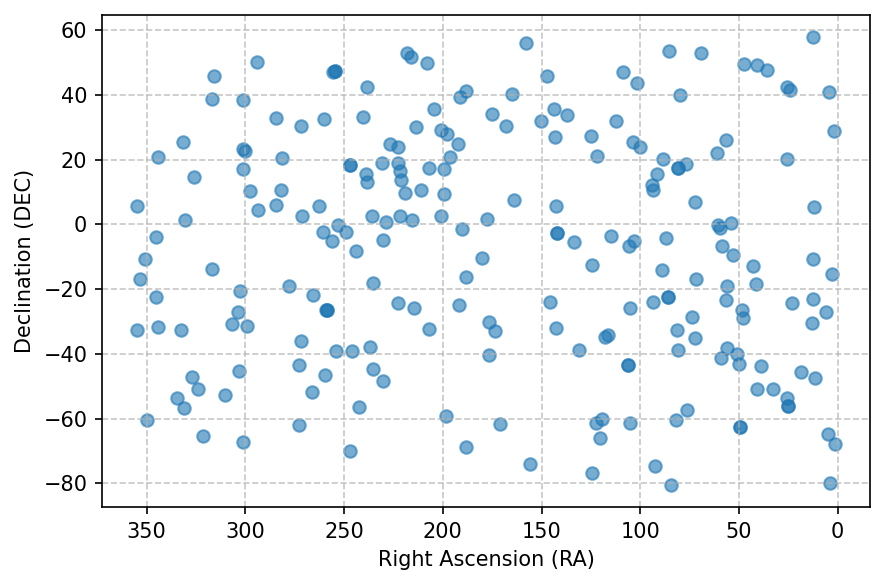

In [55]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 4), dpi=150)
plt.scatter(merged_df['RA'], merged_df['DEC'], alpha=0.6)
plt.xlabel('Right Ascension (RA)')
plt.ylabel('Declination (DEC)')
plt.grid(True, linestyle='--', alpha=0.7)

# Invert the x-axis to match astronomical convention (RA increases to the left)
plt.gca().invert_xaxis()

plt.tight_layout()
plt.savefig('../figures/ra_dec.png', dpi=300)
plt.show()


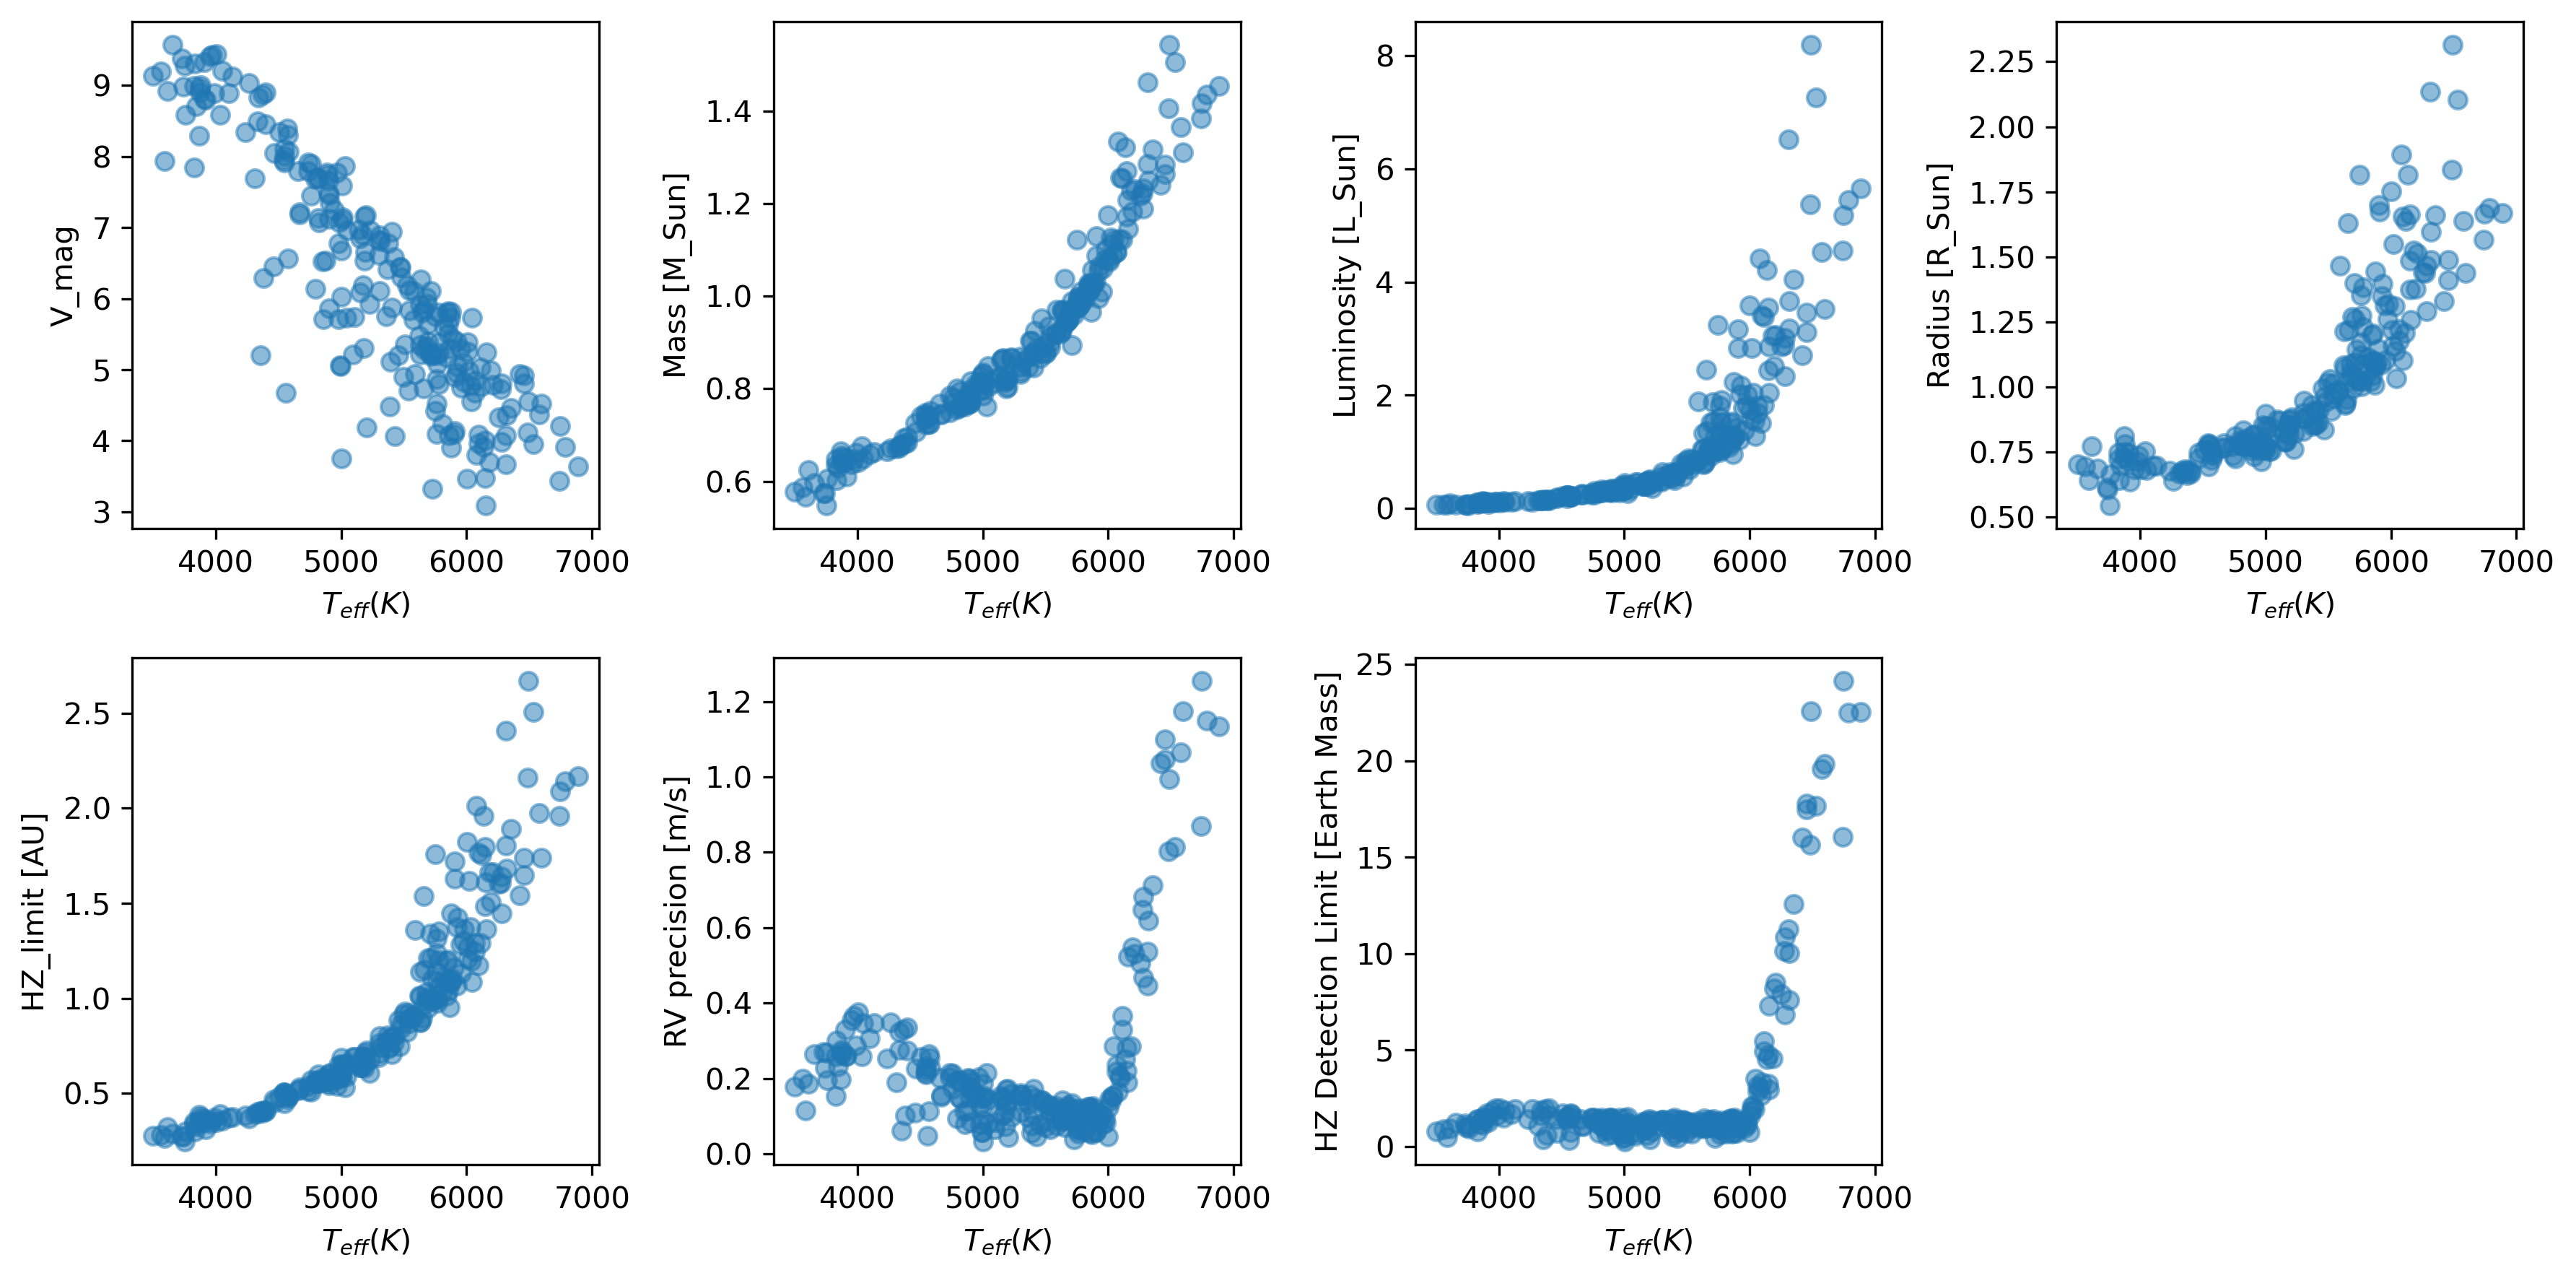

In [58]:
# Create the plot
fig, axs = plt.subplots(2, 4, figsize=(12, 6), dpi=300)
# fig.suptitle('Stellar Properties as a Function of Temperature', fontsize=16)

# Flatten the axs array for easier iteration
axs = axs.flatten()

# List of columns to plot
columns = ['V_mag', 'Mass [M_Sun]', 'Luminosity [L_Sun]', 'Radius [R_Sun]', 'HZ_limit [AU]', 
           'RV precision [m/s]', 'HZ Detection Limit [Earth Mass]']

# Plot each column
for i, col in enumerate(columns):
    axs[i].scatter(merged_df['T_eff [K]'], merged_df[col], alpha=0.5)
    axs[i].set_xlabel('$T_{eff} (K)$')
    axs[i].set_ylabel(col)

# Remove the last unused subplot
fig.delaxes(axs[-1])

# Adjust the layout and display the plot
plt.tight_layout()
plt.savefig('../figures/stellar_properties_vs_temperature.png')
plt.show()


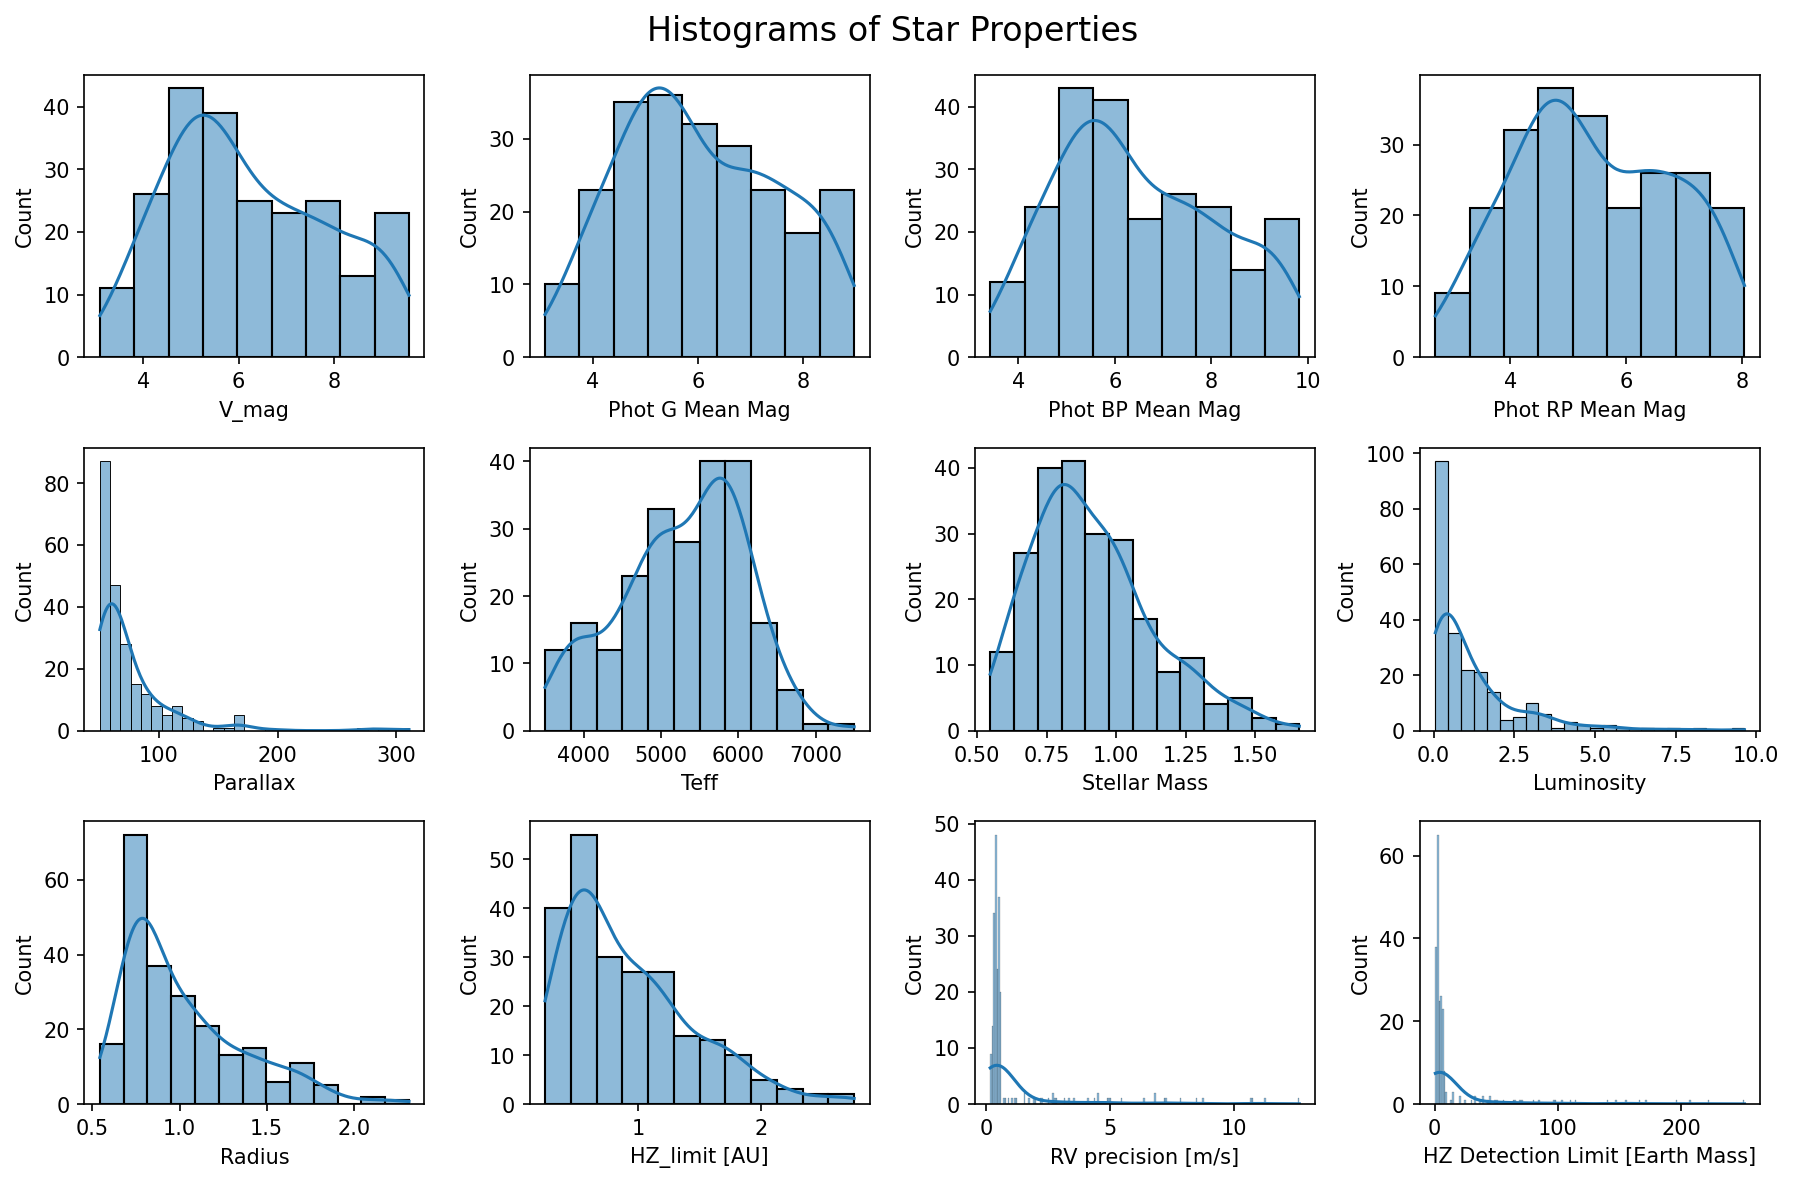

In [181]:
import matplotlib.pyplot as plt
import seaborn as sns

# List of columns to plot
columns_to_plot = [
    'V_mag', 'Phot G Mean Mag', 'Phot BP Mean Mag', 'Phot RP Mean Mag',
    'Parallax', 'T_eff [K]', 'Stellar Mass', 'Luminosity [L_Sun]', 'Radius [R_Sun]', 'HZ_limit [AU]', 'RV precision [m/s]',
    'HZ Detection Limit [Earth Mass]'
]

# Set up the plot
fig, axes = plt.subplots(3, 4, figsize=(12, 8), dpi=150)
fig.suptitle('Histograms of Star Properties', fontsize=16)

# Flatten the axes array for easy iteration
axes = axes.flatten()

# Create histograms
for i, column in enumerate(columns_to_plot):
    sns.histplot(data=merged_df, x=column, kde=True, ax=axes[i])
    axes[i].set_xlabel(column)
    axes[i].set_ylabel('Count')

# Adjust layout and display
plt.tight_layout()
plt.subplots_adjust(top=0.93)
plt.savefig('../figures/star_properties_histograms.png')
plt.show()


# additional codes (not used for now)

In [17]:
import astropy.units as u
from astropy.coordinates import SkyCoord
from astroquery.gaia import Gaia

coord = SkyCoord(ra=280, dec=-60, unit=(u.degree, u.degree), frame='icrs')
width = u.Quantity(0.1, u.deg)
height = u.Quantity(0.1, u.deg)
r = Gaia.query_object_async(coordinate=coord, width=width, height=height)
r
# r.pprint(max_lines=12, max_width=130)

INFO: Query finished. [astroquery.utils.tap.core]


dist,solution_id,designation,source_id,random_index,ref_epoch,ra,ra_error,dec,dec_error,parallax,parallax_error,parallax_over_error,pm,pmra,pmra_error,pmdec,pmdec_error,ra_dec_corr,ra_parallax_corr,ra_pmra_corr,ra_pmdec_corr,dec_parallax_corr,dec_pmra_corr,dec_pmdec_corr,parallax_pmra_corr,parallax_pmdec_corr,pmra_pmdec_corr,astrometric_n_obs_al,astrometric_n_obs_ac,astrometric_n_good_obs_al,astrometric_n_bad_obs_al,astrometric_gof_al,astrometric_chi2_al,astrometric_excess_noise,astrometric_excess_noise_sig,astrometric_params_solved,astrometric_primary_flag,nu_eff_used_in_astrometry,pseudocolour,pseudocolour_error,ra_pseudocolour_corr,dec_pseudocolour_corr,parallax_pseudocolour_corr,pmra_pseudocolour_corr,pmdec_pseudocolour_corr,astrometric_matched_transits,visibility_periods_used,astrometric_sigma5d_max,matched_transits,new_matched_transits,matched_transits_removed,ipd_gof_harmonic_amplitude,ipd_gof_harmonic_phase,ipd_frac_multi_peak,ipd_frac_odd_win,ruwe,scan_direction_strength_k1,scan_direction_strength_k2,scan_direction_strength_k3,scan_direction_strength_k4,scan_direction_mean_k1,scan_direction_mean_k2,scan_direction_mean_k3,scan_direction_mean_k4,duplicated_source,phot_g_n_obs,phot_g_mean_flux,phot_g_mean_flux_error,phot_g_mean_flux_over_error,phot_g_mean_mag,phot_bp_n_obs,phot_bp_mean_flux,phot_bp_mean_flux_error,phot_bp_mean_flux_over_error,phot_bp_mean_mag,phot_rp_n_obs,phot_rp_mean_flux,phot_rp_mean_flux_error,phot_rp_mean_flux_over_error,phot_rp_mean_mag,phot_bp_rp_excess_factor,phot_bp_n_contaminated_transits,phot_bp_n_blended_transits,phot_rp_n_contaminated_transits,phot_rp_n_blended_transits,phot_proc_mode,bp_rp,bp_g,g_rp,radial_velocity,radial_velocity_error,rv_method_used,rv_nb_transits,rv_nb_deblended_transits,rv_visibility_periods_used,rv_expected_sig_to_noise,rv_renormalised_gof,rv_chisq_pvalue,rv_time_duration,rv_amplitude_robust,rv_template_teff,rv_template_logg,rv_template_fe_h,rv_atm_param_origin,vbroad,vbroad_error,vbroad_nb_transits,grvs_mag,grvs_mag_error,grvs_mag_nb_transits,rvs_spec_sig_to_noise,phot_variable_flag,l,b,ecl_lon,ecl_lat,in_qso_candidates,in_galaxy_candidates,non_single_star,has_xp_continuous,has_xp_sampled,has_rvs,has_epoch_photometry,has_epoch_rv,has_mcmc_gspphot,has_mcmc_msc,in_andromeda_survey,classprob_dsc_combmod_quasar,classprob_dsc_combmod_galaxy,classprob_dsc_combmod_star,teff_gspphot,teff_gspphot_lower,teff_gspphot_upper,logg_gspphot,logg_gspphot_lower,logg_gspphot_upper,mh_gspphot,mh_gspphot_lower,mh_gspphot_upper,distance_gspphot,distance_gspphot_lower,distance_gspphot_upper,azero_gspphot,azero_gspphot_lower,azero_gspphot_upper,ag_gspphot,ag_gspphot_lower,ag_gspphot_upper,ebpminrp_gspphot,ebpminrp_gspphot_lower,ebpminrp_gspphot_upper,libname_gspphot
,,,,,yr,deg,mas,deg,mas,mas,mas,,mas / yr,mas / yr,mas / yr,mas / yr,mas / yr,,,,,,,,,,,,,,,,,mas,,,,1 / um,1 / um,1 / um,,,,,,,,mas,,,,,deg,,,,,,,,deg,deg,deg,deg,,,electron / s,electron / s,,mag,,electron / s,electron / s,,mag,,electron / s,electron / s,,mag,,,,,,,mag,mag,mag,km / s,km / s,,,,,,,,d,km / s,K,log(cm.s**-2),dex,,km / s,km / s,,mag,mag,,,,deg,deg,deg,deg,,,,,,,,,,,,,,,K,K,K,log(cm.s**-2),log(cm.s**-2),log(cm.s**-2),dex,dex,dex,pc,pc,pc,mag,mag,mag,mag,mag,mag,mag,mag,mag,
float64,int64,object,int64,int64,float64,float64,float32,float64,float32,float64,float32,float32,float32,float64,float32,float64,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int16,int16,int16,int16,float32,float32,float32,float32,int16,bool,float32,float32,float32,float32,float32,float32,float32,float32,int16,int16,float32,int16,int16,int16,float32,float32,int16,int16,float32,float32,float32,float32,float32,float32,float32,float32,float32,bool,int16,float64,float32,float32,float32,int16,float64,float32,float32,float32,int16,float64,float32,float32,float32,float32,int16,int16,int16,int16,int16,float32,float32,float32,float32,float32,int16,int16,int16,int16,float32,float32,float32,float32,float32,float32,fl

In [5]:
import os
from datetime import datetime
import numpy as np
import pandas as pd
from astropy import units as u
from astropy_healpix import HEALPix

In [6]:
# Set input parameters below ===========
DR3            = True            # Set it to False to select EDR3
target_table   = 'gaia_source'   # Alternative values: 'Astrophysical_parameters/astrophysical_parameters/', etc
hpx_level      = 6
lon            =  80.894 * u.deg # Right Ascencion (ICRS)
lat            = -69.756 * u.deg # Declination (ICRS)
radius         = 0.5     * u.deg

print(f'Input Variables: ')
print(f'* HEALPix level                      = {hpx_level} ')
print(f'* ICRS longitude (~ Right Ascension) = {lon} ')
print(f'* ICRS latitude  (~ Declination)     = {lat} ')
print(f'* Radius                             = {radius} ')
print()

Input Variables: 
* HEALPix level                      = 6 
* ICRS longitude (~ Right Ascension) = 80.894 deg 
* ICRS latitude  (~ Declination)     = -69.756 deg 
* Radius                             = 0.5 deg 



In [7]:
# Download basic parameters ============
output_file    = 'bulk_download_files.txt'
output_dir     = 'downloads'

if os.path.isdir(f'{output_dir}'):
    now          = datetime.now()
    output_dir_2 = output_dir + now.strftime("_%Y-%m-%d")
    print(f'>> Warning: {output_dir} directory exist. Creating alternative directory: {output_dir_2}')
    print()
    output_dir   = output_dir_2
else:
    os.system(f'mkdir {output_dir}')

print(f'Files will be downloaded to: {output_dir}')

Files will be downloaded to: downloads
